In [2]:
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
base_Edu=pd.read_parquet("D:\\2AD ENSAE\\Projet de statistique appliquée\\Dossier travail\\base_EduP.parquet")
base_Edu

,unique_learner_id,days_between_signup_and_first_activity,days_between_order_and_first_activity,first_theory_activity_date,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,weekly_study_objective,...,avg_correct_answer_rate_last_7d_before_theory_exam,bool_last_activity_exam_success,nb_weeks_weekly_study_objective_reached,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
0,8419571457653010970,0,0,2019-11-06 11:48:23.000000,69,0,0,0,9,<NA>,...,NaN,<NA>,0,0,0,1,0.0,0.0,0.0,100.0
1,8146721487194078646,4,-21,2019-12-25 12:46:52.000000,187,0,0,0,120,<NA>,...,NaN,<NA>,0,0,0,1,0.0,0.0,0.0,100.0
2,-3485592876691787799,0,0,2023-05-20 17:36:26.000000,509,0,0,0,54,120,...,NaN,<NA>,0,1,0,0,0.0,100.0,0.0,0.0
3,-3219165913854507531,0,0,2020-02-15 22:04:04.000000,16,0,33,0,33,<NA>,...,0.7750,0,0,0,0,1,0.0,0.0,0.0,100.0
4,-4837902186147543536,0,1,2024-01-04 14:45:07.000000,213,0,0,0,153,120,...,NaN,<NA>,0,1,0,0,0.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,8165520323374530945,276,90,2019-10-09 20:18:32.000000,354,0,0,0,2,<NA>,...,NaN,<NA>,0,0,0,1,0.0,0.0,0.0,100.0
199996,-5789763106649329852,203,202,2021-04-29 11:34:50.000000,580,0,52,0,60,240,...,0.8375,0,0,10,0,0,0.0,100.0,0.0,0.0
199997,-5428281942184437473,393,393,2020-08-30 21:23:02.000000,653,0,0,0,72,<NA>,...,NaN,<NA>,0,0,0,1,0.0,0.0,0.0,100.0
199998,-2624787454535895380,1,1,2021-06-14 19:16:10.000000,467,0,0,0,493,240,...,NaN,<NA>,0,1,0,0,0.0,100.0,0.0,0.0


In [4]:
print(base_Edu.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 470 entries, unique_learner_id to pct_no_objective_weeks
dtypes: Int64(65), boolean(254), datetime64[us](1), float64(150)
memory usage: 438.9 MB
None


La base de données compte donc 470 variables dont 65 de type Int, 254 de type boolean, 1 de type datetime et 150 de type float soit au total 254 variables qualitatives (**boolean**) et 214 variables quantitatives(**float + int** en excluant les identifiants) sans oublier la variable de type **datetime**.

Nous commencons par épurer la base données avant de passer à la réduction de dimension. On s'intéressera aux valeurs manquantes. 

In [5]:
missing_value=(base_Edu.isnull().sum()/len(base_Edu))
missing_value[missing_value>0]
missing_value[missing_value>0].describe()

count    404.000000
mean       0.744336
std        0.278540
min        0.048770
25%        0.664535
50%        0.843895
75%        0.919200
max        1.000000
dtype: float64

La base de données comporte donc 404 variables avec valeurs manquantes sur le total des 470 variables de la base ce qui n'est pas du tout négligeable. Voyons combien de valeurs manquantes at-on par type de variables. 

In [6]:
print(base_Edu.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(base_Edu.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(base_Edu.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(base_Edu.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

48  variables de type int ont des valeurs manquantes
103  variables de type float ont des valeurs manquantes
253  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


La seule variable de type datetime n'a donc pas de valeurs manquantes.  Analysons de plus près les proportions de valeurs manquantes des autres types

In [7]:
miss_bool=base_Edu.select_dtypes("boolean").isnull().sum()/len(base_Edu)
miss_bool[miss_bool>0].describe()

count    253.000000
mean       0.904117
std        0.071375
min        0.694955
25%        0.839120
50%        0.884215
75%        1.000000
max        1.000000
dtype: float64

Les variables de type boolean comportent pratiquement tous assez de valeurs manquantes avec un minimum de 69% et un maximum de 100% du total des observations

Les valeurs manquantes de la base ne sont pas complètement aléatoires. Elles ne sont pas pour la plupart le fruit d'une mauvaise collecte de données. La présence de valeurs manquantes dans cette base est due à diverses raisons notamment le fait que plusieurs individus de la base n'ont pas encore passé d'examen pour le permis. Plusieurs questions(variables) n'ont de sens que dans le cas où le premier examen est passé. Il y a donc une part d'information apporté par ces valeurs manquantes que nous devons inclure dans nos analyses. Pour les variables booléenne, nous pouvons régler ce prblème c'est à dire prendre en compte l'information apportée par ces valeurs manquantes en transformant les variables booléennes en variable catégorielles en considérant les valeurs manquantes comme une catégorie(True=1,False=0 et NA=2).

In [8]:
#print(base_Edu.select_dtypes('category'))
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=base_Edu.select_dtypes("boolean").columns
for col in colboo:
    base_Edu[col] = encode_column_with_na(base_Edu[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories


Passons maintenant aux variables quantitatives (int+float)

In [9]:
miss_quant=base_Edu.select_dtypes(include=["int","float"]).isnull().sum()/len(base_Edu)
miss_quant[miss_quant>0].describe()

count    151.000000
mean       0.476624
std        0.290993
min        0.048770
25%        0.183470
50%        0.482500
75%        0.737020
max        0.940580
dtype: float64

On enregistre 151 variables quantitatives avec valeurs manquantes. On a un minimum d'environ 4.8% et un maximum de 94% de valeurs manquantes par rapport au total d'observation(nous rappelons 200000 obervations). La nature des variables et la distribution des valeurs manquantes dans ce cas ne facilite pas la capture de l'information apportée par la présence de ces valeurs manquantes. On pourrait opter pour une imputation par KNN ou par imputation itérative (MICE) mais cela risque de modifier et significativement les corrélations existant déjà entre les variables introduisant ainsi un important biais et au vue de la taille de l'echantillon, cela demanderait un temps d'excution énorme. On choisit ici donc de procéder à une imputation par la médiane après suppression des variables ayant un taux élevé de valeurs manquantes pour minimiser le biais. Cela permettra de ne pas trop distordre les distributions existentes.

In [10]:
miss_quant[miss_quant<=0.20].describe()

count    111.000000
mean       0.058967
std        0.075779
min        0.000000
25%        0.000000
50%        0.000000
75%        0.126815
max        0.195385
dtype: float64

Nous choisissons le seuil de 20% de valeurs manquantes. Ce seuil nous parait raisonnable puisqu'il est relativement faible et n'entraine pas la suppression d'un grand nombre de variables quantitatives (111 sont conservées sur un total de 151)

In [11]:
#suppression des variables avec plus de 20% de valeurs manquantes
base_Edu=base_Edu.drop(columns=miss_quant[miss_quant>0.20].index)
#Imputation par la médiane
col=base_Edu.select_dtypes(exclude='category').columns
base_Edu[col] = base_Edu[col].fillna(base_Edu[col].median())

In [11]:
base_Edu.isnull().any().sum()

0

Plus aucune valeur manquante. La base de données enfin prête, on peut passer aux opérations de réduction de dimension

<br/>
<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
3- Auto Encoder </u>
</p>
<br/>

Le calibrage des hyperparamètres tels que le nombre de couche, les fonctions d'activations, le type de normalisation est détaillé dans l'annexe du fichier AutoEncoder. Ont été retenus les hyperparamètre suivant : 
* Type de normalisation : MinMax
* Nombre de couche : Une couche cachée en encodeur et au niveau du décodeur
* Fonctions d'activation : **Linear**  en encodeur (dernière couche) avec en couche cachée **relu**  de l'encodeur et **sigmoid** en décodeur toujours avec **relu** en couche cachée. 

Nous nous concentrerons donc maintenant sure le choix de la dimension latente. 

### Choix du Nombre Optimal de Dimensions Latentes pour un Autoencodeur : Une Analyse Basée sur l’Information Mutuelle
Dans le cadre de la réduction de dimension à l’aide d’un autoencodeur, l’un des défis majeurs consiste à choisir un nombre optimal de dimensions latentes permettant d’atteindre un compromis entre compacité de la représentation et préservation de l’information essentielle. Pour guider ce choix, nous nous appuyons sur une mesure clé : l’information mutuelle.

L’information mutuelle est une mesure issue de la théorie de l’information qui quantifie la dépendance entre deux ensembles de variables. Plus précisément, dans notre contexte, elle permet d’évaluer dans quelle mesure les variables latentes conservent l’information contenue dans les variables d’origine. Formellement, l’information mutuelle entre deux variables aléatoires $(X)$ et $(Z)$ est donnée par :


$I(X,Z) = \sum_{x \in X} \sum_{z \in Z} P(x, z) \log \frac{P(x, z)}{P(x) P(z)}$

où $(P(x, z))$ est la distribution conjointe de $(X)$ et $(Z)$, et $(P(x))$, $(P(z))$ sont leurs distributions marginales respectives.

Dans le contexte d’un autoencodeur, cette mesure nous permet de quantifier la capacité des dimensions latentes à encoder efficacement l’information contenue dans les données initiales. Une information mutuelle élevée signifie que la représentation latente conserve beaucoup d’information sur les données originales, tandis qu’une information mutuelle faible suggère une perte d’information plus importante.


Nous calculerons ici l'information mutuelle totale (ou cumulé) qui mesure le total d'information détenue parl'ensemble des variables de la dimension latente les données originales. 

Nous commencons d'abord par exclure les identifiants ainsi que la variable de type datetime de la base qui ne présentent aucun intérêt pour notre auto encoder.
Et pour des raisons liées à la puissance de calcul, nous utiliserons dans cette première partie 15000 observations. 

In [ ]:
base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1).head(15000)

2025-03-22 11:34:11.681256: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-22 11:34:11.688975: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-22 11:34:11.706415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742643251.727104 4164209 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742643251.732576 4164209 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742643251.761800 4164209 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

 46/329 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-03-22 11:35:18.797295: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025-03-22 11:36:17.288860: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


 46/329 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

2025-03-22 11:37:15.100341: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025-03-22 11:39:01.605333: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


 47/329 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-03-22 11:40:03.396568: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025-03-22 11:42:55.418562: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


 47/329 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-03-22 11:43:55.235391: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025-03-22 11:47:32.398361: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


 40/329 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

2025-03-22 11:48:28.668444: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025-03-22 11:52:53.296504: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


 43/329 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-03-22 11:53:54.555847: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025-03-22 11:59:20.284568: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


 44/329 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-03-22 12:00:20.899591: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025-03-22 12:06:47.728543: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


 54/329 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-03-22 12:07:46.916132: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025-03-22 12:14:49.602819: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


 37/329 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

2025-03-22 12:15:48.531352: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025-03-22 12:24:03.710891: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


 53/329 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

2025-03-22 12:25:02.503428: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


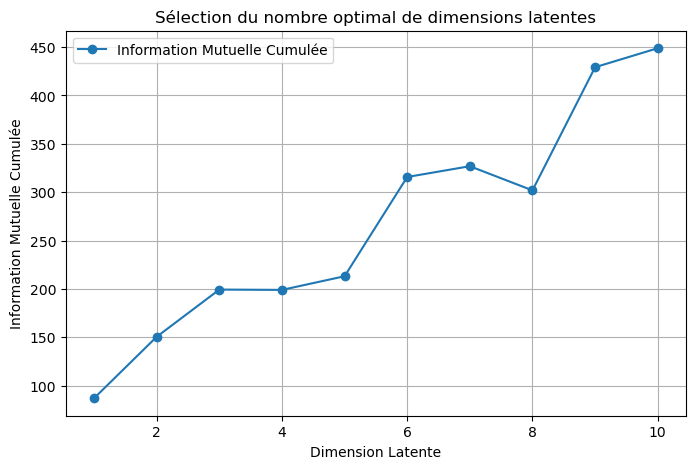

In [ ]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

final_data = np.hstack([encoded_cats, scaled_nums])
final_columns = list(encoded_cat_columns) + list(numerical_cols)

x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)
input_dim = x_train.shape[1]
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

# === 3. Tester différentes dimensions latentes et calculer l'information mutuelle cumulée ===
mutual_info_scores = []
latent_dims = range(1, 11)

for encoding_dim in latent_dims:
    input_img = Input(shape=(input_dim,))
    Hidden1 = Dense(358, activation='relu', kernel_initializer=initializer)(input_img)
    encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)
    Hidden_output1 = Dense(358, activation='relu', kernel_initializer=initializer)(encoded)
    decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test), verbose=0)
    
    encoder_model = Model(input_img, encoded)
    encoded_imgs = encoder_model.predict(x_train)
    
    mi_scores = np.array([
        np.sum([mutual_info_regression(x_train[:, j].reshape(-1, 1), encoded_imgs[:, i]) 
                 for j in range(x_train.shape[1])])
        for i in range(encoding_dim)
    ])
    
    mutual_info_scores.append(np.sum(mi_scores))

# === 4. Tracer la courbe de l'information mutuelle cumulée ===
plt.figure(figsize=(8, 5))
plt.plot(latent_dims, mutual_info_scores, marker='o', linestyle='-', label="Information Mutuelle Cumulée")
plt.xlabel("Dimension Latente")
plt.ylabel("Information Mutuelle Cumulée")
plt.title("Sélection du nombre optimal de dimensions latentes")
plt.legend()
plt.grid()
plt.show()


En regardant la courbe de l’information mutuelle cumulée, on voit qu’elle augmente de façon régulière et significative jusqu’à 3 dimensions latentes. Cette progression fluide suggère que chaque nouvelle dimension ajoutée jusqu’à ce point capte une information pertinente et exploitable. Si l’autoencodeur captait simplement du bruit dès le départ, on s’attendrait à voir une progression plus chaotique ou des paliers apparaître plus tôt. Or, ici, l’augmentation continue et sans rupture jusqu’à 3 peut être interprétée comme le signe que ces dimensions sont réellement en train de structurer l’information utile présente dans les données d’origine.  

Au-delà de 3, le comportement de la courbe devient plus irrégulier, avec des fluctuations et des paliers, ce qui suggère que la manière dont l’information est captée change. Cela pourrait signifier que l’autoencodeur commence à modéliser des détails plus fins, mais aussi potentiellement du bruit ou des variations moins essentielles. Dans une optique d’interprétabilité, il est donc raisonnable de s’arrêter à 3, un seuil où l’information semble encore bien organisée et exploitable sans risquer de perdre en clarté.

En choisissant une dimension latente de 3, on privilégie un compromis entre la quantité d'information retenue et son interprétabilité. Aller au-delà pourrait certes maximiser l'information captée, mais au prix d’une complexité accrue et d’une possible dégradation de la qualité de l'information. Ici, 3 semble être un point d'équilibre où l'on capture l’essentiel de la structure des données tout en évitant d’intégrer des éléments plus aléatoires ou difficiles à interpréter.

Pour la construction de notre autoencodeur, nous exploiterons la totalité de la base de données pour lui permettre d'apprendre un maximum d'information. 

In [114]:
base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1)

Epoch 1/50
547/547 [==============================] - 11s 18ms/step - loss: 0.0407 - val_loss: 0.0360
Epoch 2/50
547/547 [==============================] - 8s 15ms/step - loss: 0.0359 - val_loss: 0.0354
Epoch 3/50
547/547 [==============================] - 8s 15ms/step - loss: 0.0353 - val_loss: 0.0349
Epoch 4/50
547/547 [==============================] - 8s 15ms/step - loss: 0.0349 - val_loss: 0.0345
Epoch 5/50
547/547 [==============================] - 8s 16ms/step - loss: 0.0346 - val_loss: 0.0342
Epoch 6/50
547/547 [==============================] - 11s 20ms/step - loss: 0.0343 - val_loss: 0.0339
Epoch 7/50
547/547 [==============================] - 8s 15ms/step - loss: 0.0340 - val_loss: 0.0337
Epoch 8/50
547/547 [==============================] - 8s 15ms/step - loss: 0.0338 - val_loss: 0.0335
Epoch 9/50
547/547 [==============================] - 8s 15ms/step - loss: 0.0337 - val_loss: 0.0334
Epoch 10/50
547/547 [==============================] - 8s 15ms/step - loss: 0.0335 - val_

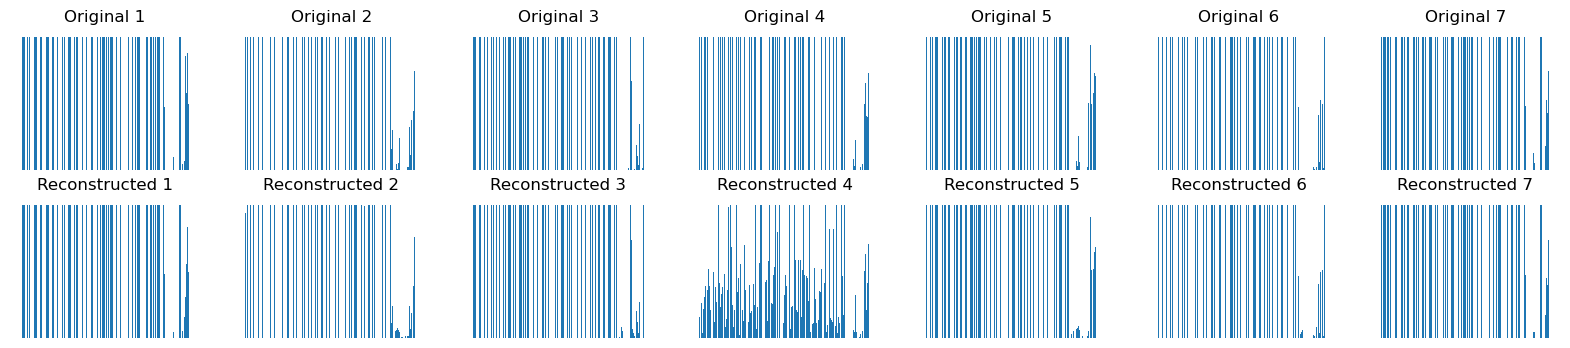

Erreur moyenne de reconstruction : 0.0321


In [115]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
#input_dim = x_train.shape[1]

# === 2. Définition de l'autoencodeur ===
input_dim = x_train.shape[1]  # Assurez-vous que x_train est bien défini
encoding_dim = 3

# Initialisation déterministe des poids
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

input_img = Input(shape=(input_dim,))
# Encodeur
Hidden1 = Dense(358, activation='relu', kernel_initializer=initializer)(input_img)
#Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden1)
#Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)

# Décodeur
Hidden_output1 = Dense(358, activation='relu', kernel_initializer=initializer)(encoded)
#Hidden_output2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden_output1)
#Hidden_output3 = Dense(256, activation='relu', kernel_initializer=initializer)(Hidden_output2)
decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)#Plus touche

# Modèle autoencodeur
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=1)

# Modèle de l'encodeur seul
encoder = Model(input_img, encoded)

# Représentations encodées (latent space)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# === 4. Visualisation des performances ===
n = 7
plt.figure(figsize=(20, 4))

for i in range(n):
    # Données originales
    ax = plt.subplot(2, n, i + 1)
    plt.bar(range(len(x_test[i])), x_test[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.bar(range(len(decoded_imgs[i])), decoded_imgs[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.show()

# Analyse des erreurs de reconstruction
reconstruction_error = np.mean((x_test - decoded_imgs) ** 2, axis=1)
print(f"Erreur moyenne de reconstruction : {np.mean(reconstruction_error):.4f}")


In [16]:
#!pip install tensorflow

Nous obtenons une erreur de reconstruction égale à 0.0321. Ce qui indique que l'autoencodeur parvient à reconstruire les données d'origine avec une précision raisonnable. Nous maintenons donc 3 comme dimension de l'espace latent. 

Aussi Le graphique précédent fait une comparaison entre les 7 premières données originales et leurs versions reconstruites (pour une dimension k=3 de l'espace latent). Et la ressemblence obervée est très forte. Cela témoigne du fait que la valeur k=3 de l'hyperparamètre suffit à capturer efficacement la structure initiale de nos données. 

In [17]:
import tensorflow as tf

# Supposons que ton autoencoder soit défini sous le nom 'autoencoder'
autoencoder.save("autoencoder.h5")  # Sauvegarde au format HDF5

In [ ]:
import tensorflow as tf

# Chargement du modèle
autoencoder = tf.keras.models.load_model("autoencoder.h5")

# Vérification de la structure du modèle
autoencoder.summary()


Nous allons maintenant passer à l'interprétation des nos 5 variables latentes. Mais pour le faire il nous faut savoir quelles variables d'origines ont plus d'influence sur chacun des variables latentes. Pour capturer cette information, nous utiliserons la méthode GradiantExplainer de la bibliothèque shap qui nous donnera une approximation de l'effet d'une pertubation élémentaire de chacune des variables d'origine suer chacune des variables latentes. 

In [116]:
import shap

# === 2. SHAP pour l'analyse des variables d'origine ===
# Adaptation du modèle pour SHAP ===
# Le modèle doit inclure les couches d'entrée jusqu'à l'encodage
#explainer = shap.DeepExplainer(encoder, x_train)  # Sous-échantillon de référence
explainer = shap.GradientExplainer(encoder, x_train)
# === 2. Récupérer les valeurs SHAP pour les données de test ===
shap_values = explainer.shap_values(x_test[:len(x_test) // 4])  # Analyser un sous-échantillon de test

d:\Anaconda\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Le point de départ le plus simple pour une interprétation globale avec SHAP consiste à examiner la valeur SHAP absolue moyenne de chaque caractéristique sur l'ensemble des données. Cela permet de quantifier, en moyenne, l'ampleur (positive ou négative) de la contribution de chaque caractéristique (variables d'origines) aux variables latentes. Les caractéristiques ayant des valeurs SHAP absolues moyennes plus élevées sont plus influentes.

In [117]:
import pandas as pd

# Pour chaque dimension latente
for i in range(3):  # 10 dimensions latentes
    shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
    # Créer un DataFrame des valeurs SHAP pour les variables d'origine
    shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
    # Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
    mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    print(f"Les variables les plus influentes pour la {i+1}-ème dimension latente:")
    print(mean_shap_values.head(20))  # Afficher les 5 variables les plus influentes pour la dimension latente i+1


Les variables les plus influentes pour la 1-ème dimension latente:
is_first_exam_success_1                              0.896397
is_first_exam_success_2                              0.846775
pct_study_objective_not_reached                      0.701806
ratio_serie_chapter_median                           0.588582
choice_00_bc4d741f-f4c0-4820-87c7-bf94a9245703_1     0.515800
choice_01_bc4d741f-f4c0-4820-87c7-bf94a9245703_1     0.511012
is_correct_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1    0.440678
has_passed_theory_exam_1                             0.438279
choice_02_bc4d741f-f4c0-4820-87c7-bf94a9245703_1     0.405505
choice_01_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1     0.396993
choice_00_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1     0.385974
is_correct_bc4d741f-f4c0-4820-87c7-bf94a9245703_1    0.378674
choice_03_bc4d741f-f4c0-4820-87c7-bf94a9245703_1     0.377822
has_passed_theory_exam_0                             0.284109
is_correct_bc4d741f-f4c0-4820-87c7-bf94a9245703_2    0.274183
cho

La sortie précédente donne pour chacune des variables de la dimension latente les variables d'origine les plus influentes c'est à dire celle ayant les valeurs absolues moyenne shap les plusz élévé. Mais cette sortie serait plus intéressante sous forme de graphique.

Pour chacune des variables latentes, nous procèderons aussi à la représentation des **Parcelles d'essaims d'abeilles** encore appelées **Beeswarm**. Les graphiques Beeswarm sont une représentation plus complexe et plus riche en informations des valeurs SHAP qui révèle non seulement l'importance relative des caractéristiques, mais également leurs relations réelles avec le résultat prévu. Dans ce cas de l'autoencoder, elle nous permet de connaitre quel aspect de la variable d'origine est capté par la variable latente. Un shap négatif signifie ici que la variable d’entrée agit dans le sens opposé à ce que la dimension latente représente.

La représentation des **Beeswarm** se fera avec les variables les plus influences permettant d'avoir un cumul de valeur absolue moyenne shap de 40% du total. 

Le seuil de **40% du cumul des valeurs absolues moyennes SHAP**, combiné à un **classement des variables par ordre d’influence**, permet de capturer l’essentiel de l’information de manière plus **pure et ciblée**. En sélectionnant uniquement les variables les plus impactantes, on évite le bruit des variables secondaires tout en garantissant une interprétation **claire et pertinente** des dimensions latentes de l’autoencodeur. Ce choix assure ainsi une **représentation optimisée**, où seules les variables ayant un effet significatif sur la dimension étudiée sont mises en avant, améliorant la lisibilité et la qualité des analyses.

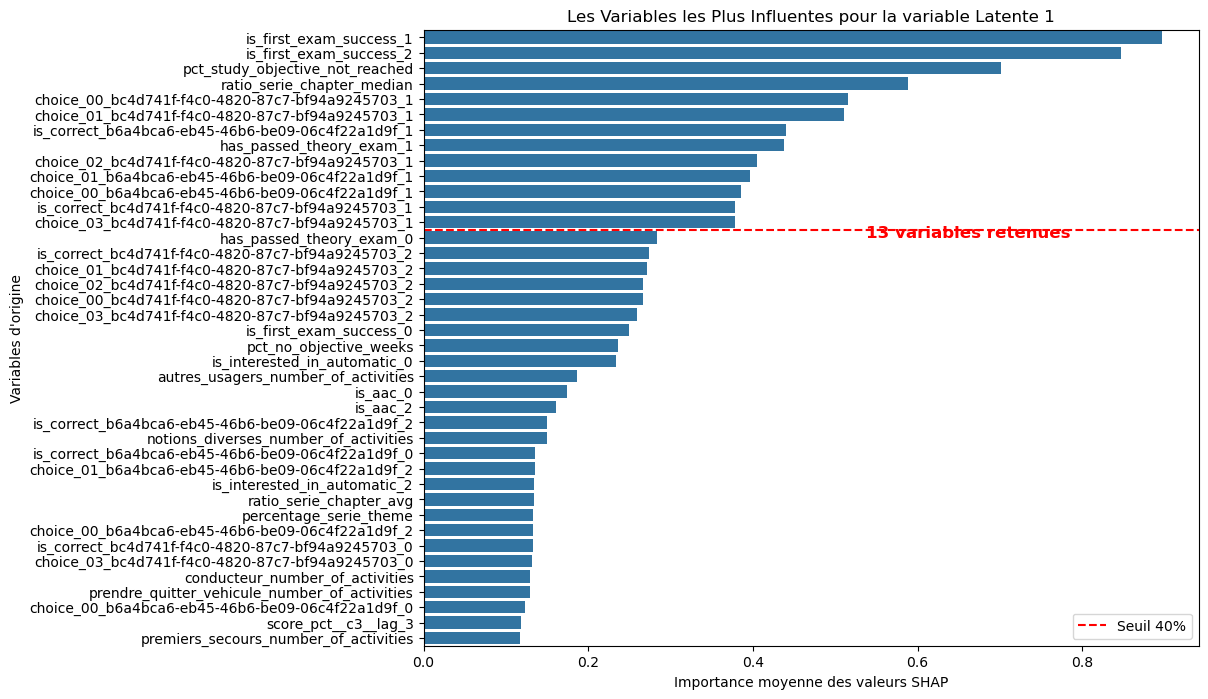

Nombre de variables nécessaires pour couvrir 40% de l'importance totale : 13


In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choix de la dimension latente
i = 0  # Modifier si besoin

# Extraction des SHAP values pour cette dimension latente
shap_val = shap_values[:, :, i]  

# Création d'un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  

# Importance moyenne absolue des SHAP values (classement décroissant)
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  

# Calcul de l'importance cumulée
cumulative_importance = mean_shap_values.cumsum() / mean_shap_values.sum()

# Trouver le nombre de variables nécessaires pour atteindre 30% de l'importance cumulée
num_selected_features = (cumulative_importance <= 0.4).sum()

# Affichage du barplot avec trait horizontal pour 25%
plt.figure(figsize=(10, 8))
sns.barplot(x=mean_shap_values.head(40).values, y=mean_shap_values.head(40).index, orient='h')

# Ajout d'un trait horizontal au niveau du seuil des 25%
plt.axhline(y=num_selected_features - 0.5, color='red', linestyle='--', label="Seuil 40%")

# Annotation du nombre de variables retenues
plt.text(mean_shap_values.max() * 0.6, num_selected_features, 
         f"{num_selected_features} variables retenues", 
         color="red", fontsize=12, fontweight="bold")

# Titres et labels
plt.title(f"Les Variables les Plus Influentes pour la variable Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.legend()
plt.show()

# Affichage du nombre de variables retenues
print(f"Nombre de variables nécessaires pour couvrir 40% de l'importance totale : {num_selected_features}")


L'observation de ce graphique indique que cette première variable latente semble grandement être influencé par le passage d'un examen théorique ainsi que les performances au test. Nous nous servirons beaucoup plus dd'un beeswarm dans la suite pour une analyse plus approfondie. 

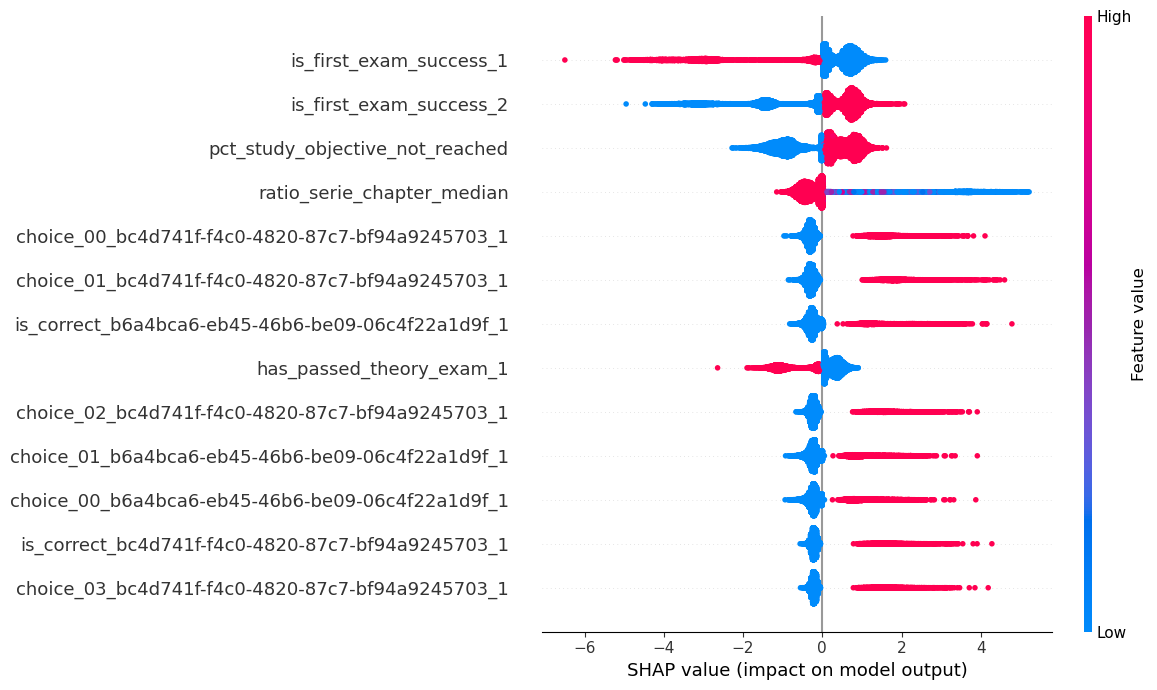

In [119]:
# Choisir la dimension latente à analyser (ex : la 5ème)
latent_dim_index = 0  

# Extraire les valeurs SHAP pour cette dimension latente
shap_val = shap_values[:, :, latent_dim_index]  # Shape : (9000, 724)

# Affichage du SHAP summary plot

shap.summary_plot(shap_val, x_test[:len(x_test) // 4], feature_names=final_columns, max_display=13,plot_size=(12, 7))

Ici on enregistre les comportements suivants : 
* is_first_exam_succes_1 : Les fortes valeurs pour cette variable correspondent à un shap négatif tandis que les faibles valeurs correspondent à un shap positif. C'est donc l'échec au premier examen qui est capturé par cette variable latente. 
* is_first_exam_succes_2 : Ici nous observons tout le comportement inverse. C'est donc le fait de ne pas disposer d'information par rapport à cette première dimension et donc certainement le fait de ne pas avoir encore été au premier examen qui est capturé probablement dû à un manque de préparation.  
* pct_study_objective_not_reached : Pour cette variable, les valeurs shap positives correspondent aux grandent valeurs de la variable. Ainsi le fait d'avoir un grand nombre d'objectif d'apprentissage non atteint emplifie l'information détenue par cette première variable latente
* choice........, is_correct : variables liées aux questions posées au test théorique et présentent en majorité. Vu que nous manquons d'informations concrète sur le sens de chacune de ces questions, on s'abstiendra de commenter la répartition des valeurs shap pour ces variables. Cependant, la présence en grand nombre de ces variables sur le graphique indique que cette dimension capture en grande partie ses performances au test théorique
* has_passed_theory_exam : Ce sont les faibles valeurs de cette variable qui correspondent aux faibles valeurs shap. Ainsi cette première variable latente capture en partie le fait de ne pas avoir passé le test théorique. 

Cette première dimension latente capture principalement **les difficultés à réussir l’examen théorique**, reflétant à la fois un **manque de préparation** et un **échec au test**. En effet, l’échec au premier examen est fortement associé à des valeurs SHAP positives, tandis que l’absence d’information sur le premier passage suggère une non-présentation, souvent due à une préparation insuffisante. De plus, un grand nombre d’objectifs d’apprentissage non atteints amplifie cette dimension, tout comme la présence massive des choix et corrections aux questions de l’examen, indiquant qu’elle est fortement liée aux performances au test. Enfin, la non-validation de l’examen accentue cette tendance. 

**Nom proposé : "Difficulté à réussir l’examen théorique"**.

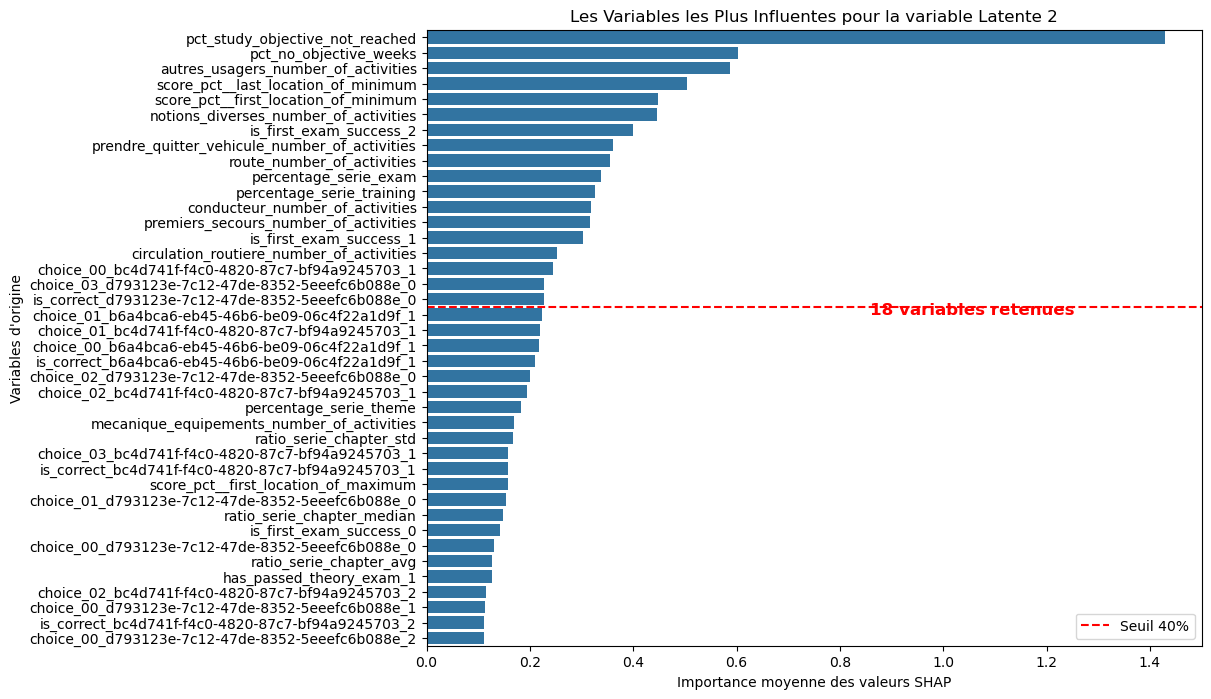

Nombre de variables nécessaires pour couvrir 40% de l'importance totale : 18


In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choix de la dimension latente
i = 1  # Modifier si besoin

# Extraction des SHAP values pour cette dimension latente
shap_val = shap_values[:, :, i]  

# Création d'un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  

# Importance moyenne absolue des SHAP values (classement décroissant)
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  

# Calcul de l'importance cumulée
cumulative_importance = mean_shap_values.cumsum() / mean_shap_values.sum()

# Trouver le nombre de variables nécessaires pour atteindre 30% de l'importance cumulée
num_selected_features = (cumulative_importance <= 0.4).sum()

# Affichage du barplot avec trait horizontal pour 25%
plt.figure(figsize=(10, 8))
sns.barplot(x=mean_shap_values.head(40).values, y=mean_shap_values.head(40).index, orient='h')

# Ajout d'un trait horizontal au niveau du seuil des 25%
plt.axhline(y=num_selected_features - 0.5, color='red', linestyle='--', label="Seuil 40%")

# Annotation du nombre de variables retenues
plt.text(mean_shap_values.max() * 0.6, num_selected_features, 
         f"{num_selected_features} variables retenues", 
         color="red", fontsize=12, fontweight="bold")

# Titres et labels
plt.title(f"Les Variables les Plus Influentes pour la variable Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.legend()
plt.show()

# Affichage du nombre de variables retenues
print(f"Nombre de variables nécessaires pour couvrir 40% de l'importance totale : {num_selected_features}")


La sortie précédente indique que cette variable semble fortement lié au noombre d'activité pratique effectué durant l'apprentissage au permis. Analysons le beeswarm pour une analyse plus approfondie. 

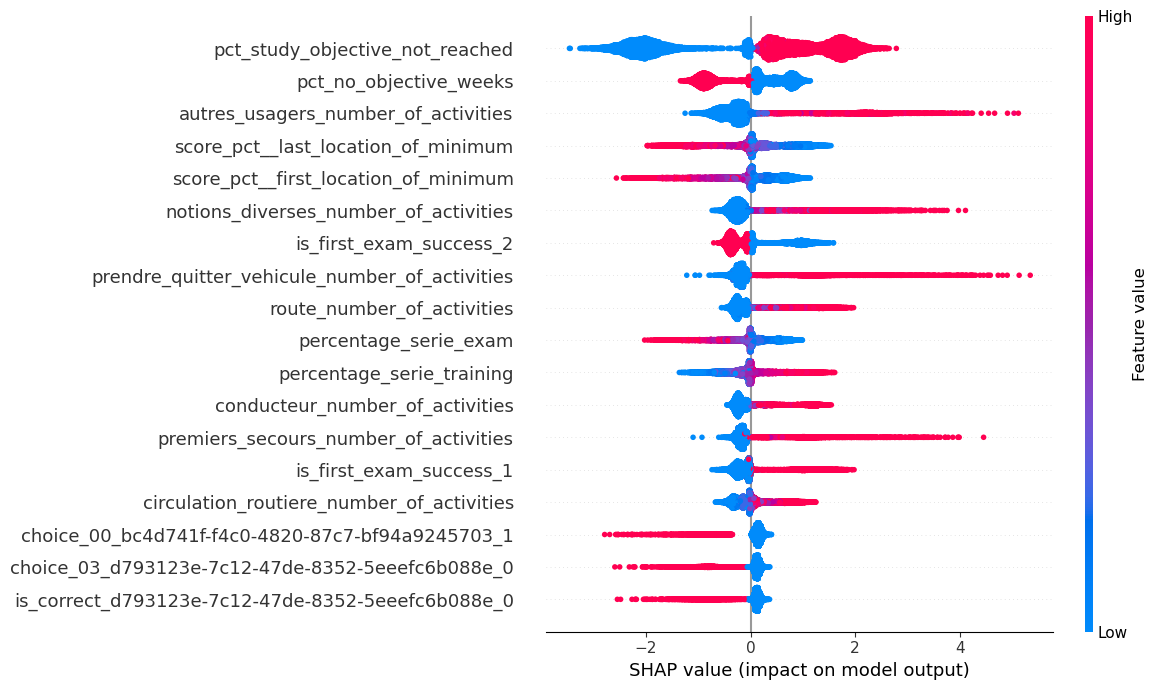

In [125]:
# Choisir la dimension latente à analyser (ex : la 5ème)
latent_dim_index = 1 

# Extraire les valeurs SHAP pour cette dimension latente
shap_val = shap_values[:, :, latent_dim_index]  # Shape : (9000, 724)

# Affichage du SHAP summary plot

shap.summary_plot(shap_val, x_test[:len(x_test) // 4], feature_names=final_columns, max_display=18,plot_size=(12, 7))

Parmi les variables qui influent le plus sur cette variable latente, nous pouvons citer : 
* pct_study_objective_not_reached : Ici les valeurs positives shap sont associées aux grandes valeurs de cette variable. Autrement dit, la deuxième variable latente semble capturer le fait d'avoir un grand nombre d'objectif d'apprentissage non atteint 
* pct_no_objective_weeks : Pour cette variable, les valeurs positives shap sont associées à aux faibles valeurs de la variable. Ainsi cette variable semble liée au fait d'avoir un faible nombre de semaine sans objcetif. Cela traduit une certaine régularité dans l'apprentissage. 
* variables liées au nombre d'activité pratiques liées à divers chapitre du cours exercé (autres_usagers_number_of_activities,notions_diverses_number_of_activities,conducteur_number_of_activities,route_number_of_activities, premiers_secours_number_of_activities, premiers_secours_number_of_activities, circulation_routiere_number_of_activities) : Pour toutes ces variables, les valeurs shap positives sont associées aux grandes valeurs de ces variables. Ainsi cette variable latente est fortement liée au fait de pratiquer enormément d'activité pratique. 
is_first_exam_succes_2 : les valeurs shap positives sont liées au faible valeurs (0) de cette variable. Cette deuxième dimension semble liéeau fait de s'étre au moins présenter une fois déjà à l'exam et donc de pouvoir fournir une réponse à cette question.  
is_first_exam_succes_1 : les valeurs shap positives sont liées aux grandes valeurs de cette variable. C'est donc le succès au premier examen qui est capturé ici
* percentage_serie_exam : Ici les valeurs shap positives sont associées aux faibles valeurs de cette variable. Ainsi cette dimension latente semble capturé le fait de ne pas trop pratiqué de série de type examen. 
* percentage_serie_training : Ici c'est l'inverse qui est observé. C'est pluitôt le fait d'effectuer beaucoup de série d'entrainement qui est prise en compte
* On retrouve maintenant en dernière position et très faiblement des variables liées aux questions posées au test théorique. 

Cette deuxième dimension latente semble refléter un **profil d’apprentissage actif mais imparfaitement ciblé**. Elle est activée par une forte implication dans les activités pratiques liées à différents chapitres du cours, combinée à une pratique intensive de séries d'entraînement, et à une certaine régularité dans l’étude (faible nombre de semaines sans objectifs). Toutefois, elle capte également le fait de **ne pas atteindre les objectifs pédagogiques fixés**, et d’**éviter les séries de type examen**, suggérant un apprentissage soutenu mais parfois désorganisé ou inefficace. Le fait de s’être présenté au moins une fois à l’examen  et même d’y avoir réussi  est aussi positivement associé à cette dimension. Les questions de l’examen n’apparaissent qu’en fin de classement, ce qui confirme que cette variable latente est bien plus liée **aux efforts d’apprentissage** qu’au test lui-même. 

**Nom proposé : "Investissement pratique avec lacunes d’apprentissage"**.



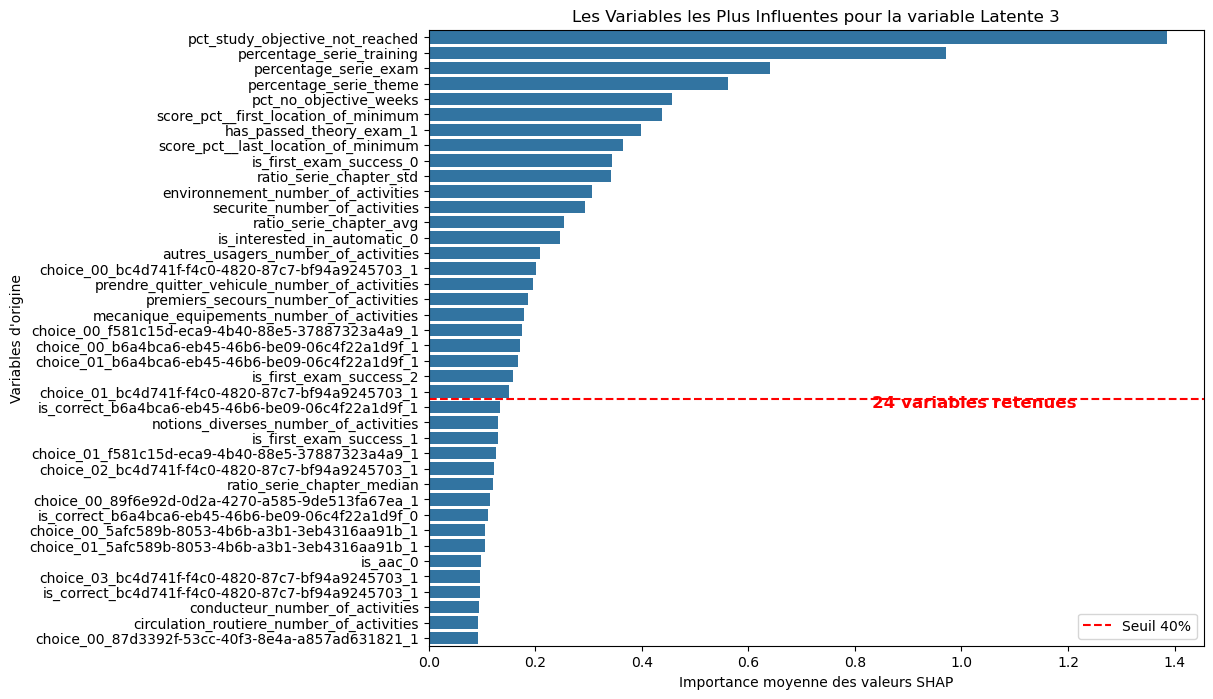

Nombre de variables nécessaires pour couvrir 40% de l'importance totale : 24


In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choix de la dimension latente
i = 2  # Modifier si besoin

# Extraction des SHAP values pour cette dimension latente
shap_val = shap_values[:, :, i]  

# Création d'un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  

# Importance moyenne absolue des SHAP values (classement décroissant)
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  

# Calcul de l'importance cumulée
cumulative_importance = mean_shap_values.cumsum() / mean_shap_values.sum()

# Trouver le nombre de variables nécessaires pour atteindre 30% de l'importance cumulée
num_selected_features = (cumulative_importance <= 0.40).sum()

# Affichage du barplot avec trait horizontal pour 25%
plt.figure(figsize=(10, 8))
sns.barplot(x=mean_shap_values.head(40).values, y=mean_shap_values.head(40).index, orient='h')

# Ajout d'un trait horizontal au niveau du seuil des 25%
plt.axhline(y=num_selected_features - 0.5, color='red', linestyle='--', label="Seuil 40%")

# Annotation du nombre de variables retenues
plt.text(mean_shap_values.max() * 0.60, num_selected_features, 
         f"{num_selected_features} variables retenues", 
         color="red", fontsize=12, fontweight="bold")

# Titres et labels
plt.title(f"Les Variables les Plus Influentes pour la variable Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.legend()
plt.show()

# Affichage du nombre de variables retenues
print(f"Nombre de variables nécessaires pour couvrir 40% de l'importance totale : {num_selected_features}")


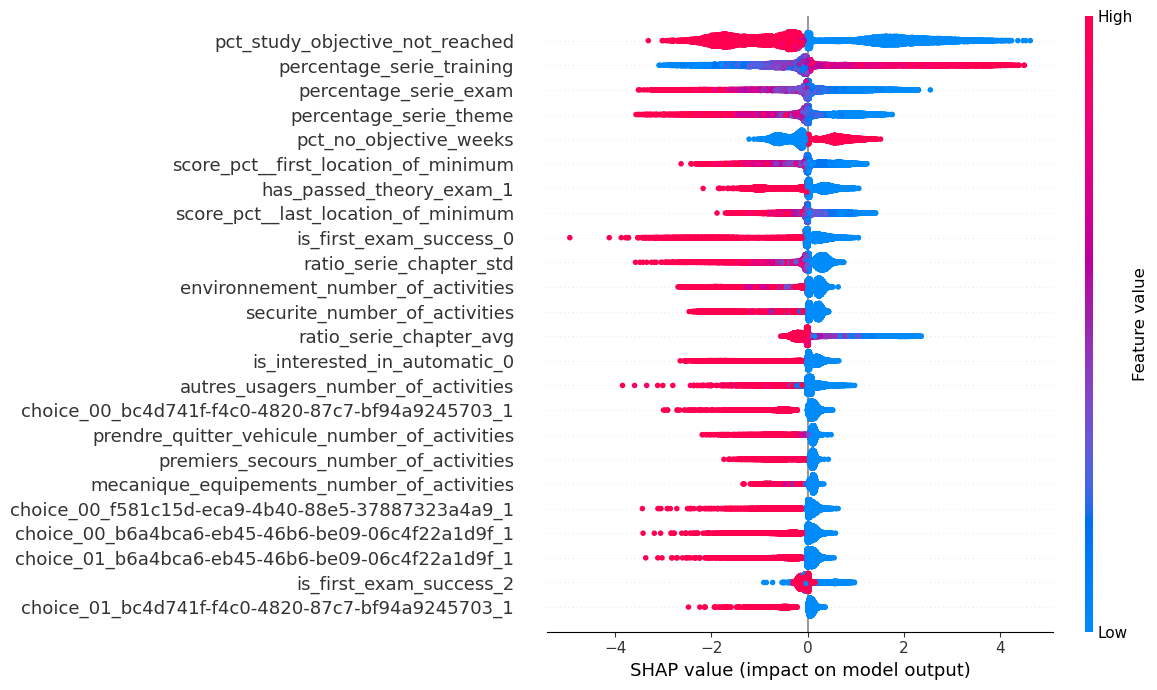

In [123]:
# Choisir la dimension latente à analyser (ex : la 5ème)
latent_dim_index = 2  

# Extraire les valeurs SHAP pour cette dimension latente
shap_val = shap_values[:, :, latent_dim_index]  # Shape : (9000, 724)

# Affichage du SHAP summary plot

shap.summary_plot(shap_val, x_test[:len(x_test) // 4], feature_names=final_columns, max_display=24,plot_size=(12, 7))

Parmi les variables qui influent le plus sur cette dimension latente, nous pouvons citer : 
* pct_study_objective_not_reached : Ici les valeurs positives shap sont associées aux petites valeurs de cette variable. Autrement dit, la troisième variable latente semble capturer le fait d'avoir un petit nombre d'objectif d'apprentissage non atteint  
* percentage_serie_training : Ici les valeurs shap positives sont associées aux grandes valeurs de cette variable. Ainsi cette dimension latente semble capturer le fait de pratiquer énormément de de type examen.
* percentage_serie_exam : Ici c'est l'inverse qui est observé. C'est plutôt le fait d'effectuer un faible nombre de série de type examen qui est prise en compte
* pct_no_objective_weeks : Pour cette variable, les valeurs positives shap sont associées aux grandes valeurs de la variable. Ainsi la troisième variable semble liée au fait d'avoir un grand nombre de semaine sans objcetif. Cela traduit un certain manque de  régularité dans l'apprentissage. 
* has_passed_theory_exam_1 : les valeurs positives shap sont associées aux faibles valeurs de la variable. Ainsi la troisième variable latente capture en partie le fait de ne pas encore avoir passé l'examen théorique. 
is_first_exam_succes_0 : On observe le même comportement que la précédente. C'est le fait de réussir le premier examen théorique lorsque vous le passez qui amplifie l'information contenu dans la variable. 
* variables liées au nombre d'activité pratiques liées à divers chapitre du cours exercé (environnement_number_of_activities, securite_number_of_activities, autres_usagers_number_of_activities,prendre_quitter_vehicule_number_of_activities, premiers_secours_number_of_activities, mecanique_equipements_number_of_activities) : Pour toutes ces variables, les valeurs shap positives sont associées aux petites valeurs de ces variables. Ainsi cette variable latente est fortement liée au fait de pratiquer peu d'activités pratiques. 

Cette troisième dimension latente semble refléter un **manque d’engagement réel dans l’apprentissage**, associé à une préparation superficielle ou passive. Elle est activée par un **faible nombre d’objectifs non atteints**, ce qui pourrait à première vue indiquer une bonne progression, mais cela contraste avec d'autres signaux clairs : l’étudiant **pratique peu d’activités concrètes**, **suit peu de séries d’examen**, et présente une **irrégularité dans le suivi des objectifs hebdomadaires**. De plus, elle capte le **fait de ne pas encore s’être présenté à l’examen**, voire **de ne pas l’avoir réussi**. L’intensité dans les séries d'entraînement semble être la seule activité présente, ce qui traduit plutôt une stratégie d'entraînement **centrée sur la répétition**, mais **sans réelle mise en condition ni approfondissement par la pratique**. 

**Nom proposé : "Préparation passive et irrégulière"**.



## Modélisation

L'autoencodeur nous a permis de catégoriser divers aspects liés à l'apprentissage au permis de conduire à travers les trois axes retenus. Dans cette partie, nous d'une base **base_assu** renseignant pour des individus sur les valeurs des mêmes variables que celles de la base **base_Edu** et sur des variables liées à la sinistralité. L'objectif ici est d'éffectuer une projection des variables liées à l'apprentissage au permuis de conduire dans la dimension latente pour voir quels aspects liés à l'apprentissage permet eventuellement de mieux expliquer la sinistralité. 

In [130]:
base_Edu0=pd.read_parquet("D:\\2AD ENSAE\\Projet de statistique appliquée\\Dossier travail\\base_EduP.parquet")

In [131]:
base_assu=pd.read_parquet("D:\\2AD ENSAE\\Projet de statistique appliquée\\Dossier travail\\base_assu.parquet")

In [132]:
base_assu

,unique_learner_id,learner_id,job_number,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,...,var_Assurance6,var_Assurance7,var_Assurance8,var_Assurance9,var_Assurance10,var_Assurance11,var_Assurance12,var_Assurance13,var_Assurance14,var_Assurance15
0,-5911177134761577615,2032674,5952452787,157,157,195,0,0,0,42,...,0,0,0,0,0,0,0,0,0,0
1,8022228279541171063,893514,6956583814,7,8,819,0,0,0,26,...,0,0,0,0,0,0,0,0,0,0
2,4508976855497020988,2858364,1547176297,0,-32,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2395000730355774468,1362204,3464728867,0,0,376,0,0,0,288,...,0,1,3,0,0,0,0,0,0,0
4,1056703805299986938,1054230,1534163688,64,0,691,0,109,0,156,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69393,-872146316430440559,3793717,2234733812,0,0,372,0,57,18,193,...,0,0,0,0,0,0,0,0,0,0
69394,-3415706474168471139,2775978,1784701608,109,109,270,0,50,0,51,...,0,0,0,0,0,0,0,0,0,0
69395,-1958338314080661076,2102507,7135995107,672,665,613,0,93,321,603,...,0,0,0,0,0,0,0,0,0,0
69396,-7394860117143701634,2862021,1866260241,113,114,76,0,0,0,120,...,0,0,0,0,0,0,0,0,0,0


La base **base_assu** comporte donc apparemment 69398 observations avec 957 variables (ce qui semble peu réaliste) puisque nous sommes avoir censé avoir 470 variables comme dans la base **base_Edu** avec des variables renseignant sur la sinistralité. 

In [133]:
base_assu["learner_id"].unique()

<IntegerArray>
[2032674,  893514, 2858364, 1362204, 1054230,  292705,  532289, 2410220,
  243343, 1874398,
 ...
 1810679, 3156244, 2289722, 3334229,  556084, 3793717, 2775978, 2102507,
 2862021, 3025251]
Length: 66692, dtype: Int64

Nous avons donc 66692 identifiants uniques dans la base de données avec que la base comporte 69398 observations. Cela laisse présentir la présence de plusieurs doublons dans la base de données. 

Les doublons seront supprimés afin d’éviter toute sur-représentation d’observations identiques, ce qui pourrait fausser les analyses statistiques et biaiser les résultats des modèles. Cette étape permettra également d’assurer la qualité et la cohérence des données.

In [135]:
base_assu = base_assu.drop_duplicates()
base_assu

,unique_learner_id,learner_id,job_number,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,...,var_Assurance6,var_Assurance7,var_Assurance8,var_Assurance9,var_Assurance10,var_Assurance11,var_Assurance12,var_Assurance13,var_Assurance14,var_Assurance15
0,-5911177134761577615,2032674,5952452787,157,157,195,0,0,0,42,...,0,0,0,0,0,0,0,0,0,0
1,8022228279541171063,893514,6956583814,7,8,819,0,0,0,26,...,0,0,0,0,0,0,0,0,0,0
2,4508976855497020988,2858364,1547176297,0,-32,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2395000730355774468,1362204,3464728867,0,0,376,0,0,0,288,...,0,1,3,0,0,0,0,0,0,0
4,1056703805299986938,1054230,1534163688,64,0,691,0,109,0,156,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69393,-872146316430440559,3793717,2234733812,0,0,372,0,57,18,193,...,0,0,0,0,0,0,0,0,0,0
69394,-3415706474168471139,2775978,1784701608,109,109,270,0,50,0,51,...,0,0,0,0,0,0,0,0,0,0
69395,-1958338314080661076,2102507,7135995107,672,665,613,0,93,321,603,...,0,0,0,0,0,0,0,0,0,0
69396,-7394860117143701634,2862021,1866260241,113,114,76,0,0,0,120,...,0,0,0,0,0,0,0,0,0,0


On se retrouve après avoir appliqué un traitement censé supprimer les éventuelles valeurs manquantes à 66692 observations. Cela confirme qu'on avait bienn des doublons au départ dans la base. 

Passons à l'analyse des variables liées à la sinistralité  que nous sommes censé obtenir en supprimant de cette base les variables communes avec la base_Edu. 

In [136]:
base_assu1=base_assu.drop(columns=base_Edu0.columns,axis=1)

In [137]:
base_assu1

,learner_id,job_number,unique_learner_id_1,days_between_signup_and_first_activity_1,days_between_order_and_first_activity_1,days_between_first_and_last_activities_1,chapter_before_success_count_1,serie_before_success_count_1,quiz_before_success_count_1,theory_activities_total_1,...,var_Assurance6,var_Assurance7,var_Assurance8,var_Assurance9,var_Assurance10,var_Assurance11,var_Assurance12,var_Assurance13,var_Assurance14,var_Assurance15
0,2032674,5952452787,-5911177134761577615,157,157,195,0,0,0,42,...,0,0,0,0,0,0,0,0,0,0
1,893514,6956583814,8022228279541171063,7,8,819,0,0,0,26,...,0,0,0,0,0,0,0,0,0,0
2,2858364,1547176297,4508976855497020988,0,-32,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1362204,3464728867,2395000730355774468,0,0,376,0,0,0,288,...,0,1,3,0,0,0,0,0,0,0
4,1054230,1534163688,1056703805299986938,64,0,691,0,109,0,156,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69393,3793717,2234733812,-872146316430440559,0,0,372,0,57,18,193,...,0,0,0,0,0,0,0,0,0,0
69394,2775978,1784701608,-3415706474168471139,109,109,270,0,50,0,51,...,0,0,0,0,0,0,0,0,0,0
69395,2102507,7135995107,-1958338314080661076,672,665,613,0,93,321,603,...,0,0,0,0,0,0,0,0,0,0
69396,2862021,1866260241,-7394860117143701634,113,114,76,0,0,0,120,...,0,0,0,0,0,0,0,0,0,0


Nous obtenons d'autres variables qui semblent être des duplications des variables communes. Vérifions si elles ne sont que de simples duplications. 

In [ ]:
base_assu1.iloc[:,:-16]

,learner_id,job_number,unique_learner_id_1,days_between_signup_and_first_activity_1,days_between_order_and_first_activity_1,days_between_first_and_last_activities_1,chapter_before_success_count_1,serie_before_success_count_1,quiz_before_success_count_1,theory_activities_total_1,...,avg_correct_answer_rate_last_7d_before_theory_exam_1,bool_last_activity_exam_success_1,nb_weeks_weekly_study_objective_reached_1,nb_weeks_weekly_study_objective_not_reached_1,nb_weeks_no_activity_1,nb_weeks_no_weekly_study_objective_1,pct_study_objective_reached_1,pct_study_objective_not_reached_1,pct_study_objective_no_activity_1,pct_no_objective_weeks_1
0,2032674,5952452787,-5911177134761577615,157,157,195,0,0,0,42,...,NaN,<NA>,0,1,0,0,0.00,100.00,0.0,0.0
1,893514,6956583814,8022228279541171063,7,8,819,0,0,0,26,...,NaN,<NA>,0,0,0,1,0.00,0.00,0.0,100.0
2,2858364,1547176297,4508976855497020988,0,-32,0,0,0,0,1,...,NaN,<NA>,0,1,0,0,0.00,100.00,0.0,0.0
3,1362204,3464728867,2395000730355774468,0,0,376,0,0,0,288,...,NaN,<NA>,0,0,0,1,0.00,0.00,0.0,100.0
4,1054230,1534163688,1056703805299986938,64,0,691,0,109,0,156,...,0.686275,0,0,8,0,0,0.00,100.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69393,3793717,2234733812,-872146316430440559,0,0,372,0,57,18,193,...,NaN,0,0,10,0,0,0.00,100.00,0.0,0.0
69394,2775978,1784701608,-3415706474168471139,109,109,270,0,50,0,51,...,0.752174,0,0,0,0,7,0.00,0.00,0.0,100.0
69395,2102507,7135995107,-1958338314080661076,672,665,613,0,93,321,603,...,0.791477,0,1,2,0,0,33.33,66.67,0.0,0.0
69396,2862021,1866260241,-7394860117143701634,113,114,76,0,0,0,120,...,NaN,<NA>,0,1,0,0,0.00,100.00,0.0,0.0


In [ ]:
# Récupération des variables communes à la base Edu
B1=base_assu[base_Edu0.columns].drop(columns='first_theory_activity_date',axis=1)
# Récupération des potentiells duplications. (var_1)
B2=base_assu1.iloc[:,:-16].drop(columns=['learner_id','job_number'])


In [140]:
B1

,unique_learner_id,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,weekly_study_objective,is_first_exam_success,...,avg_correct_answer_rate_last_7d_before_theory_exam,bool_last_activity_exam_success,nb_weeks_weekly_study_objective_reached,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
0,-5911177134761577615,157,157,195,0,0,0,42,120,<NA>,...,NaN,<NA>,0,1,0,0,0.00,100.00,0.0,0.0
1,8022228279541171063,7,8,819,0,0,0,26,<NA>,<NA>,...,NaN,<NA>,0,0,0,1,0.00,0.00,0.0,100.0
2,4508976855497020988,0,-32,0,0,0,0,1,240,<NA>,...,NaN,<NA>,0,1,0,0,0.00,100.00,0.0,0.0
3,2395000730355774468,0,0,376,0,0,0,288,<NA>,<NA>,...,NaN,<NA>,0,0,0,1,0.00,0.00,0.0,100.0
4,1056703805299986938,64,0,691,0,109,0,156,240,False,...,0.686275,0,0,8,0,0,0.00,100.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69393,-872146316430440559,0,0,372,0,57,18,193,240,True,...,NaN,0,0,10,0,0,0.00,100.00,0.0,0.0
69394,-3415706474168471139,109,109,270,0,50,0,51,<NA>,True,...,0.752174,0,0,0,0,7,0.00,0.00,0.0,100.0
69395,-1958338314080661076,672,665,613,0,93,321,603,240,False,...,0.791477,0,1,2,0,0,33.33,66.67,0.0,0.0
69396,-7394860117143701634,113,114,76,0,0,0,120,240,<NA>,...,NaN,<NA>,0,1,0,0,0.00,100.00,0.0,0.0


In [141]:
B2

,unique_learner_id_1,days_between_signup_and_first_activity_1,days_between_order_and_first_activity_1,days_between_first_and_last_activities_1,chapter_before_success_count_1,serie_before_success_count_1,quiz_before_success_count_1,theory_activities_total_1,weekly_study_objective_1,is_first_exam_success_1,...,avg_correct_answer_rate_last_7d_before_theory_exam_1,bool_last_activity_exam_success_1,nb_weeks_weekly_study_objective_reached_1,nb_weeks_weekly_study_objective_not_reached_1,nb_weeks_no_activity_1,nb_weeks_no_weekly_study_objective_1,pct_study_objective_reached_1,pct_study_objective_not_reached_1,pct_study_objective_no_activity_1,pct_no_objective_weeks_1
0,-5911177134761577615,157,157,195,0,0,0,42,120,<NA>,...,NaN,<NA>,0,1,0,0,0.00,100.00,0.0,0.0
1,8022228279541171063,7,8,819,0,0,0,26,<NA>,<NA>,...,NaN,<NA>,0,0,0,1,0.00,0.00,0.0,100.0
2,4508976855497020988,0,-32,0,0,0,0,1,240,<NA>,...,NaN,<NA>,0,1,0,0,0.00,100.00,0.0,0.0
3,2395000730355774468,0,0,376,0,0,0,288,<NA>,<NA>,...,NaN,<NA>,0,0,0,1,0.00,0.00,0.0,100.0
4,1056703805299986938,64,0,691,0,109,0,156,240,False,...,0.686275,0,0,8,0,0,0.00,100.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69393,-872146316430440559,0,0,372,0,57,18,193,240,True,...,NaN,0,0,10,0,0,0.00,100.00,0.0,0.0
69394,-3415706474168471139,109,109,270,0,50,0,51,<NA>,True,...,0.752174,0,0,0,0,7,0.00,0.00,0.0,100.0
69395,-1958338314080661076,672,665,613,0,93,321,603,240,False,...,0.791477,0,1,2,0,0,33.33,66.67,0.0,0.0
69396,-7394860117143701634,113,114,76,0,0,0,120,240,<NA>,...,NaN,<NA>,0,1,0,0,0.00,100.00,0.0,0.0


Nous chercherons ici donc àç voir si B1 et B2  ont même nom de colonnes, est-ce qu'ils serzient des bases identiques. 

In [142]:
columnsB2=B2.columns
B2.columns=B1.columns

In [143]:
B2

,unique_learner_id,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,weekly_study_objective,is_first_exam_success,...,avg_correct_answer_rate_last_7d_before_theory_exam,bool_last_activity_exam_success,nb_weeks_weekly_study_objective_reached,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
0,-5911177134761577615,157,157,195,0,0,0,42,120,<NA>,...,NaN,<NA>,0,1,0,0,0.00,100.00,0.0,0.0
1,8022228279541171063,7,8,819,0,0,0,26,<NA>,<NA>,...,NaN,<NA>,0,0,0,1,0.00,0.00,0.0,100.0
2,4508976855497020988,0,-32,0,0,0,0,1,240,<NA>,...,NaN,<NA>,0,1,0,0,0.00,100.00,0.0,0.0
3,2395000730355774468,0,0,376,0,0,0,288,<NA>,<NA>,...,NaN,<NA>,0,0,0,1,0.00,0.00,0.0,100.0
4,1056703805299986938,64,0,691,0,109,0,156,240,False,...,0.686275,0,0,8,0,0,0.00,100.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69393,-872146316430440559,0,0,372,0,57,18,193,240,True,...,NaN,0,0,10,0,0,0.00,100.00,0.0,0.0
69394,-3415706474168471139,109,109,270,0,50,0,51,<NA>,True,...,0.752174,0,0,0,0,7,0.00,0.00,0.0,100.0
69395,-1958338314080661076,672,665,613,0,93,321,603,240,False,...,0.791477,0,1,2,0,0,33.33,66.67,0.0,0.0
69396,-7394860117143701634,113,114,76,0,0,0,120,240,<NA>,...,NaN,<NA>,0,1,0,0,0.00,100.00,0.0,0.0


In [144]:
B1.equals(B2)

True

B2 n'est donc qu'une simple duplication de B1

In [145]:
base_assu1=base_assu1.iloc[:,-16:]

On peut donc restreindre sans crainte la base **base_assu** aux variables de la base **base_Edu**

In [146]:
base_assu=base_assu.drop(columns=columnsB2,axis=1).drop(columns=['learner_id','job_number','unique_learner_id','first_theory_activity_date'])
#base_assu=base_assu[base_Edu.columns]
#B[base_assu[:,-16:].columns]=base_assu[:,-16:]
base_assu

,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,weekly_study_objective,is_first_exam_success,days_between_booking_and_exam,...,var_Assurance6,var_Assurance7,var_Assurance8,var_Assurance9,var_Assurance10,var_Assurance11,var_Assurance12,var_Assurance13,var_Assurance14,var_Assurance15
0,157,157,195,0,0,0,42,120,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,0
1,7,8,819,0,0,0,26,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,0
2,0,-32,0,0,0,0,1,240,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,0
3,0,0,376,0,0,0,288,<NA>,<NA>,<NA>,...,0,1,3,0,0,0,0,0,0,0
4,64,0,691,0,109,0,156,240,False,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69393,0,0,372,0,57,18,193,240,True,0,...,0,0,0,0,0,0,0,0,0,0
69394,109,109,270,0,50,0,51,<NA>,True,8,...,0,0,0,0,0,0,0,0,0,0
69395,672,665,613,0,93,321,603,240,False,2,...,0,0,0,0,0,0,0,0,0,0
69396,113,114,76,0,0,0,120,240,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,0


In [147]:
Assu=base_assu[base_AE.columns]
Assu[base_assu.iloc[:,-16:].columns]=base_assu.iloc[:,-16:]
Assu

C:\Users\HP\AppData\Local\Temp\ipykernel_1312\2155126679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Assu[base_assu.iloc[:,-16:].columns]=base_assu.iloc[:,-16:]
C:\Users\HP\AppData\Local\Temp\ipykernel_1312\2155126679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Assu[base_assu.iloc[:,-16:].columns]=base_assu.iloc[:,-16:]
C:\Users\HP\AppData\Local\Temp\ipykernel_1312\2155126679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,is_first_exam_success,percentage_activities_2_3_4h_week,percentage_activities_5_6_7h_week,...,var_Assurance6,var_Assurance7,var_Assurance8,var_Assurance9,var_Assurance10,var_Assurance11,var_Assurance12,var_Assurance13,var_Assurance14,var_Assurance15
0,157,157,195,0,0,0,42,<NA>,0.000000,0.023810,...,0,0,0,0,0,0,0,0,0,0
1,7,8,819,0,0,0,26,<NA>,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0,-32,0,0,0,0,1,<NA>,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0,0,376,0,0,0,288,<NA>,0.000000,0.010417,...,0,1,3,0,0,0,0,0,0,0
4,64,0,691,0,109,0,156,False,0.000000,0.166667,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69393,0,0,372,0,57,18,193,True,0.010363,0.010363,...,0,0,0,0,0,0,0,0,0,0
69394,109,109,270,0,50,0,51,True,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
69395,672,665,613,0,93,321,603,False,0.079602,0.184080,...,0,0,0,0,0,0,0,0,0,0
69396,113,114,76,0,0,0,120,<NA>,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


Dans la suite nous préfèrerons évoluer avec les vrais noms de nos variables liées à la sinistralité. 

In [ ]:

mapping_noms = {
    f"var_Assurance{i}": nom
    for i, nom in enumerate([
        'md_edu_score', 'exposition_previous_insurance_year', 'bodily_accident', 
        'material_accident', 'broken_glass', 'fire', 'theft', 'other', 
        'all_claims', 'bodily_accident_responsible', 'material_accident_responsible', 
        'broken_glass_responsible', 'fire_responsible', 'theft_responsible', 
        'other_responsible', 'all_claims_responsible'
    ])
}

print(mapping_noms)


{'var_Assurance0': 'md_edu_score', 'var_Assurance1': 'exposition_previous_insurance_year', 'var_Assurance2': 'bodily_accident', 'var_Assurance3': 'material_accident', 'var_Assurance4': 'broken_glass', 'var_Assurance5': 'fire', 'var_Assurance6': 'theft', 'var_Assurance7': 'other', 'var_Assurance8': 'all_claims', 'var_Assurance9': 'bodily_accident_responsible', 'var_Assurance10': 'material_accident_responsible', 'var_Assurance11': 'broken_glass_responsible', 'var_Assurance12': 'fire_responsible', 'var_Assurance13': 'theft_responsible', 'var_Assurance14': 'other_responsible', 'var_Assurance15': 'all_claims_responsible'}


In [149]:
Assu=Assu.rename(columns=mapping_noms)

On applique maintenant un traitement identique à celui appliqué par la base Edu à la base Assu

In [150]:
print(Assu.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(Assu.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(Assu.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(Assu.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

24  variables de type int ont des valeurs manquantes
24  variables de type float ont des valeurs manquantes
253  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


In [151]:
miss_bool=Assu.select_dtypes("boolean").isnull().sum()/len(Assu)
miss_bool[miss_bool>0].describe()

count    253.000000
mean       0.917009
std        0.065850
min        0.498501
25%        0.865936
50%        0.904081
75%        1.000000
max        1.000000
dtype: float64

In [152]:
#print(base_Edu.select_dtypes('category'))
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=Assu.select_dtypes("boolean").columns
for col in colboo:
    Assu[col] = encode_column_with_na(Assu[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories


In [153]:
miss_bool=Assu.select_dtypes(["int","float"]).isnull().sum()/len(Assu)
miss_bool[miss_bool>0].describe()

count    48.000000
mean      0.087024
std       0.064211
min       0.004303
25%       0.023361
50%       0.058028
75%       0.157455
max       0.157455
dtype: float64

In [154]:
#Imputation par la médiane
col=Assu.select_dtypes(exclude='category').columns
Assu[col] = Assu[col].fillna(Assu[col].median())

In [155]:
Assu

,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,is_first_exam_success,percentage_activities_2_3_4h_week,percentage_activities_5_6_7h_week,...,theft,other,all_claims,bodily_accident_responsible,material_accident_responsible,broken_glass_responsible,fire_responsible,theft_responsible,other_responsible,all_claims_responsible
0,157,157,195,0,0,0,42,2,0.000000,0.023810,...,0,0,0,0,0,0,0,0,0,0
1,7,8,819,0,0,0,26,2,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0,-32,0,0,0,0,1,2,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0,0,376,0,0,0,288,2,0.000000,0.010417,...,0,1,3,0,0,0,0,0,0,0
4,64,0,691,0,109,0,156,0,0.000000,0.166667,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69393,0,0,372,0,57,18,193,1,0.010363,0.010363,...,0,0,0,0,0,0,0,0,0,0
69394,109,109,270,0,50,0,51,1,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
69395,672,665,613,0,93,321,603,0,0.079602,0.184080,...,0,0,0,0,0,0,0,0,0,0
69396,113,114,76,0,0,0,120,2,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


Notre base est maintenant prête à passer subir la réduction de dimension. 

In [156]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = Assu.iloc[:,:-16].select_dtypes(include=['int', 'float']).columns
categorical_cols = Assu.iloc[:,:-16].select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform( Assu.iloc[:,:-16][categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(Assu.iloc[:,:-16][numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

In [214]:
encoder_model = Model(input_img, encoded)
AssuAE = pd.DataFrame(encoder_model.predict(final_data), columns=["Latent1", "Latent2", "Latent3"])

2085/2085 [==============================] - 6s 3ms/step


In [215]:
#AssuAE[Assu.iloc[:,-16:].columns]=Assu.iloc[:,-16:]
Assu.index=AssuAE.index # Alignement des indices
AssuAE = pd.concat([AssuAE, Assu.iloc[:, -16:]], axis=1)


In [217]:
AssuAE

,Latent1,Latent2,Latent3,md_edu_score,exposition_previous_insurance_year,bodily_accident,material_accident,broken_glass,fire,theft,other,all_claims,bodily_accident_responsible,material_accident_responsible,broken_glass_responsible,fire_responsible,theft_responsible,other_responsible,all_claims_responsible
0,1.636357,19.162008,29.025850,80,2.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-3.418547,9.350829,33.141373,3,1.54,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.172214,21.105410,31.081198,78,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-3.768106,15.315643,44.287498,44,2.00,0,2,0,0,0,1,3,0,0,0,0,0,0,0
4,-6.087796,20.984423,27.264956,91,1.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66687,6.564033,6.842932,6.010221,16,0.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66688,7.939708,6.357448,5.618489,46,0.28,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66689,12.223451,1.626612,2.363267,91,3.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66690,12.147178,1.872622,0.019522,40,0.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Notre base est donc prête

In [218]:
AssuAE.to_parquet("AssuAE.parquet")


On cherche ici à expliquer essentiellement les variables les variables **bodily_accident** et **material_accident** via un RandomForest.
La variable **bodily_accident** pour accident corporel et material_accident pour accident materiel. 

In [219]:
AssuAE['bodily_accident'].value_counts()

bodily_accident
0    66273
1      399
2       19
3        1
Name: count, dtype: Int64

In [220]:
AssuAE['material_accident'].value_counts()

material_accident
0    57309
1     7609
2     1461
3      270
4       35
5        8
Name: count, dtype: Int64

Pour chacune des deux variables, il y a donc un déséquilibre très accentué dans la répartition des modalités de chacun de ces types de sinistres. 

In [221]:
AssuAE.iloc[:,-16:].describe()

,md_edu_score,exposition_previous_insurance_year,bodily_accident,material_accident,broken_glass,fire,theft,other,all_claims,bodily_accident_responsible,material_accident_responsible,broken_glass_responsible,fire_responsible,theft_responsible,other_responsible,all_claims_responsible
count,66692.0,66692.000000,66692.0,66692.0,66692.0,66692.0,66692.0,66692.0,66692.0,66692.0,66692.0,66692.0,66692.0,66692.0,66692.0,66692.0
mean,47.794323,1.670089,0.006597,0.172749,0.068869,0.002099,0.004798,0.02756,0.282673,0.004003,0.094494,0.0,0.0,0.0,0.0,0.098498
std,29.970857,0.954067,0.084934,0.468734,0.289689,0.046096,0.072698,0.177507,0.636151,0.064556,0.333836,0.0,0.0,0.0,0.0,0.341595
min,0.0,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,21.0,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,47.0,1.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,74.0,2.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,100.0,10.000000,3.0,5.0,5.0,2.0,3.0,4.0,7.0,2.0,5.0,0.0,0.0,0.0,0.0,5.0


Nous remarquons que les variables **broken_glass_responsible**, **fire_responsible**, **theft_responsible** et **other_responsible** sont toutes nulles puisque leurs valeurs min et max valent 0. Elles n'apportent donc aucune information concrète. Nous pouvons donc nous en débarasser. 

In [222]:
AssuAE=AssuAE.drop(columns=['broken_glass_responsible', 'fire_responsible', 'theft_responsible','other_responsible'],axis=1)

Nous séparons maintenant les bases. Une pour expliqer **material_accident** et l'autre pour expliquer **bodily_accident**

In [ ]:
# Assu2=AssuAE.drop(columns=['material_accident'],axis=1)
# Assu3=AssuAE.drop(columns=['bodily_accident'],axis=1)

L'idée de départ était de considérer chacune des modalités comme une classe pour la classification avec le RandomForest. Mais au vu du fort déséquilibre observé, on ne pourra pas procéder ainsi. 

Une première idée est de faire du rééchantillonnage. 

Nous ne pouvons bien évidemment pas faire du sous échantillonnage puisque cela reviendrait à ramener l’effectif des classes majoritaires le plus proche possible de celle des classes minoritaires. Et là on risquerait de ne plus avoir d’observation dans la base de données au vu de la distribution des classes minoritaires. 

On rejecte ici l’idée d’un rééchantillonnage synthétique pour éviter l’introduction de bruit dans nos données. De plus la plupart des techniques utilisées dans ce cas ( SMOTE, ADASYN, ROSE, GANs) n’arrivent pas facilement à générer des données  avec les mêmes types que les variables des observations de départ. Dans la plupart des cas c’est des float qui sont générés. Même si on pourrais effectivement penser à combiner avec d’autres méthodes pour avoir les mêmes types. Cela ne ferait probablement qu’augmenter le bruit.
Nous choisissons aussi de rejeter la méthode du rééchantillonnage aléatoire simple. En effet, lorsque nous prenons la distribution des classes minoritaires, on se rend compte que le déséquilibre est très accentué. Si nous voyons chaque valeur de bodily_accident comme une classe, on voit que la classe 3 par exemple n’est présente qu’une seule fois. On risquerait donc de répliquer cette même observation plusieurs fois.
Et elle n’est pas la seule. Il en sera probablement de même pour les autres classes sauf pour la classe 0.
On aboutirait donc ainsi à un overffiting inévitable.

Nous allons alors plutôt créer de nouvelles classes ici. Une pour ceux qui ont déjà eu un sinistre (modalité **1**) et une autre pour ceux qui n'en ont pas eu (modalité **0**). L'énorme effectif des individus n'ayant pas d'accidents par rapport à toutes les autres laissent supposer la présence de particularité c'est à dire des différences claires dans leur caractéristiques censé expliquer correctement cette différente au niveau de la sinistralité. On se servira du RandomForest pour voir si nos axes à elles seules résument bien ces caractéristiques entre ces deux groupes d'individus. 

On agira ensuite sur le nombre d'individus à utilisé dans chacune des classes pour le modèle pour que le déséquilibre ne soit plus aussi accentué et on combinera avec le paramètre class_weight du RandomForest auquel on donnera la valeur balanced pour qu'il puisque pondéré les classes minoritaire ce qui obligera le modèle à plus prêter attention à ces classes. 

In [685]:
import pandas as pd

# Supposons que ton DataFrame s'appelle df
# Création de la nouvelle variable
AssuAE['bodily_accident_1'] = AssuAE['bodily_accident'].apply(lambda x: 0 if x == 0 else 1)

In [686]:
# Séparer les deux classes
classe_0 = AssuAE[AssuAE['bodily_accident_1'] == 0].sample(n=2000, random_state=42)
classe_1 = AssuAE[AssuAE['bodily_accident_1'] == 1]

# Fusionner les deux ensembles
Assu_ba = pd.concat([classe_0, classe_1], axis=0).reset_index(drop=True)
Assu_ba


,Latent1,Latent2,Latent3,md_edu_score,exposition_previous_insurance_year,bodily_accident,material_accident,broken_glass,fire,theft,other,all_claims,bodily_accident_responsible,material_accident_responsible,all_claims_responsible,bodily_accident_1
0,-2.940262,8.608187,42.062908,23,2.75,0,0,0,0,0,0,0,0,0,0,0
1,-14.963070,17.044479,39.894016,4,0.95,0,0,0,0,0,0,0,0,0,0,0
2,-5.354301,7.978630,34.060146,30,3.00,0,1,0,0,1,0,2,0,1,1,0
3,14.988408,8.621962,-4.940392,14,1.00,0,0,0,0,0,0,0,0,0,0,0
4,2.912969,-2.773982,7.766098,52,0.75,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414,26.496664,-6.152694,3.146821,7,1.25,1,1,0,0,0,0,2,1,1,2,1
2415,-12.273050,16.517555,41.450035,90,3.00,1,1,0,0,0,0,2,0,0,0,1
2416,28.148899,1.214251,1.078946,61,2.75,1,1,0,0,0,1,3,1,1,2,1
2417,-3.792162,9.170339,47.802959,28,3.00,1,1,0,0,1,0,3,0,1,1,1


In [687]:
Assu_ba.to_parquet('Assu_ba')

In [688]:
import pandas as pd

# Supposons que ton DataFrame s'appelle df
# Création de la nouvelle variable
AssuAE['material_accident_1'] = AssuAE['material_accident'].apply(lambda x: 0 if x == 0 else 1)

In [689]:
# Séparer les deux classes
classe_0 = AssuAE[AssuAE['material_accident_1'] == 0].sample(n=40000, random_state=42)
classe_1 = AssuAE[AssuAE['material_accident_1'] == 1]

# Fusionner les deux ensembles
Assu_ma = pd.concat([classe_0, classe_1], axis=0).reset_index(drop=True)
Assu_ma


,Latent1,Latent2,Latent3,md_edu_score,exposition_previous_insurance_year,bodily_accident,material_accident,broken_glass,fire,theft,other,all_claims,bodily_accident_responsible,material_accident_responsible,all_claims_responsible,bodily_accident_1,material_accident_1
0,0.778934,16.292875,27.893644,40,1.00,0,0,0,0,0,0,0,0,0,0,0,0
1,-21.262892,28.115534,22.623289,35,0.92,0,0,0,0,0,0,0,0,0,0,0,0
2,-2.131846,22.220350,33.480762,60,1.00,0,0,2,0,0,0,2,0,0,0,0,0
3,-2.530489,8.747506,48.480484,41,2.75,0,0,0,0,0,0,0,0,0,0,0,0
4,-4.885248,15.152865,45.717888,31,3.00,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49378,15.728908,4.089015,5.563947,11,2.93,0,1,0,0,0,0,1,0,1,1,0,1
49379,7.124636,-3.598757,2.833200,38,0.76,0,1,0,0,0,0,1,0,0,0,0,1
49380,8.206018,9.201013,3.860116,49,2.75,0,1,2,0,0,0,3,0,0,0,0,1
49381,26.434557,7.744185,-3.121065,91,0.75,0,1,1,0,0,1,3,0,1,1,0,1


In [690]:
Assu_ma.to_parquet('Assu_ma')

## Random Forest 

### Bodily_accident

In [691]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [692]:
y = Assu_ba['bodily_accident_1']
x = Assu_ba.iloc[:,:3]#.drop(columns=['bodily_accident'], axis = 1)
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.25, random_state=42)


In [693]:
modele_rf = RandomForestClassifier(
     n_estimators=100,
     criterion='gini',
     max_depth=None,
     min_samples_split=2,
     min_samples_leaf=1,
     min_weight_fraction_leaf=0.0,
     max_features='sqrt',
     max_leaf_nodes=None,
     min_impurity_decrease=0.0,
     bootstrap=True,
     oob_score=False,
     n_jobs=None,
     random_state=42,
     verbose=0,
     warm_start=False,
     class_weight='balanced',
     ccp_alpha=0.0,
     max_samples=None,)

In [694]:
modele_rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [695]:
pd.DataFrame(modele_rf.feature_importances_, index = x_train.columns, columns = ["importance"]).sort_values("importance", ascending = False)

,importance
Latent3,0.338774
Latent1,0.331601
Latent2,0.329626


Toutes les trois classes ont apparement une importance équivalente dans cette classififcation. 

In [696]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, modele_rf.predict(x_test))*100} %")

Le pourcentage de bien classés est de : 82.8099173553719 %


Le pourcentage de bonne classification est raisonnable cependant n'est pas forcément révélatrice de la performance du modèle. En effet il dépends en grande partie de la distribution des classes dans les données tests. Nous nous appuyerons sur la matrice de confusion et la courbe ROC-AUC pour juger de la performance du modèle. 

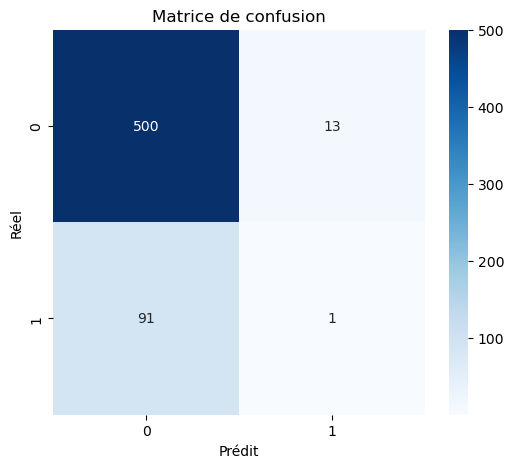

In [697]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, modele_rf.predict(x_test))
labels = np.unique(y_test)  

# Affichage avec Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


La matrice de confusion précédente indique que le modèle n'arrive pratiquement pas à identifier les classes des individus ayant déjà eu au moins un sinistre. C'est beaucoup plus à cause de la prépondérance des classes d'individus sans sinistres dans les données qui donne la précision précédemment obtenu qui ne révèle pas vraiment la réalité.  

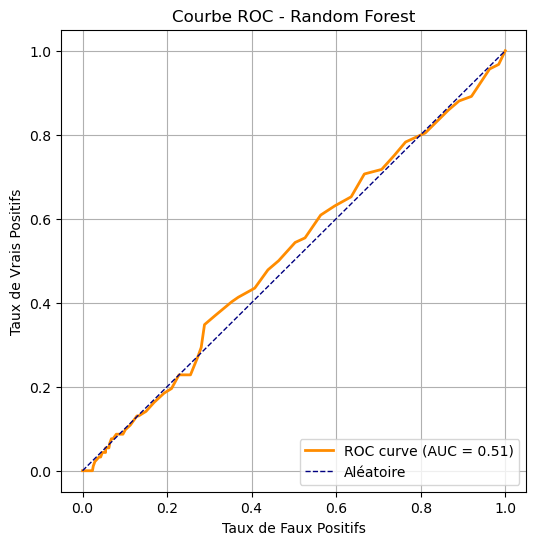

In [698]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Prédire les probabilités pour la classe positive (ici classe 1)
y_proba = modele_rf.predict_proba(x_test)[:, 1]

# Calcul des points de la courbe ROC
fpr, tpr, seuils = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Tracé de la courbe ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Aléatoire')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


La courbe précédente vient confirmer ce que nous avons précédemment dit. Le modèle n'arrive pas à distinguer les deux classes. L'information contenu dans les trois axes ne suffit pas prédire efficacement les trois axes. 

### Material_accident

In [699]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [700]:
y = Assu_ma['material_accident_1']
x = Assu_ma.iloc[:,:3]#.drop(columns=['material_accident'], axis = 1)
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.25, random_state=42)


In [701]:
modele_rf2 = RandomForestClassifier(
     n_estimators=100,
     criterion='gini',
     max_depth=None,
     min_samples_split=2,
     min_samples_leaf=1,
     min_weight_fraction_leaf=0.0,
     max_features='sqrt',
     max_leaf_nodes=None,
     min_impurity_decrease=0.0,
     bootstrap=True,
     oob_score=False,
     n_jobs=None,
     random_state=42,
     verbose=0,
     warm_start=False,
     class_weight='balanced',
     ccp_alpha=0.0,
     max_samples=None,)

In [702]:
modele_rf2.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [703]:
pd.DataFrame(modele_rf2.feature_importances_, index = x_train.columns, columns = ["importance"]).sort_values("importance", ascending = False)

,importance
Latent1,0.335380
Latent3,0.333221
Latent2,0.331398


In [704]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, modele_rf2.predict(x_test))*100} %")

Le pourcentage de bien classés est de : 79.26453912198282 %


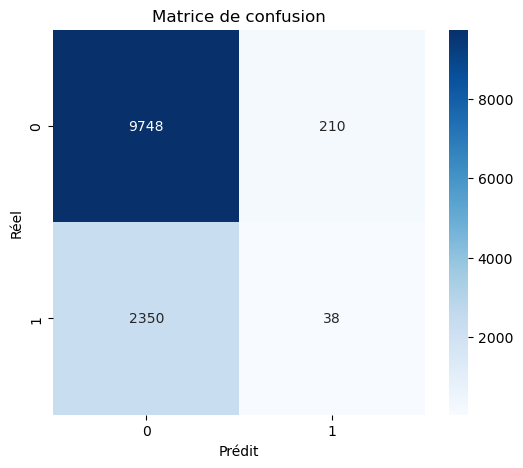

In [705]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, modele_rf2.predict(x_test))
labels = np.unique(y_test)  

# Affichage avec Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


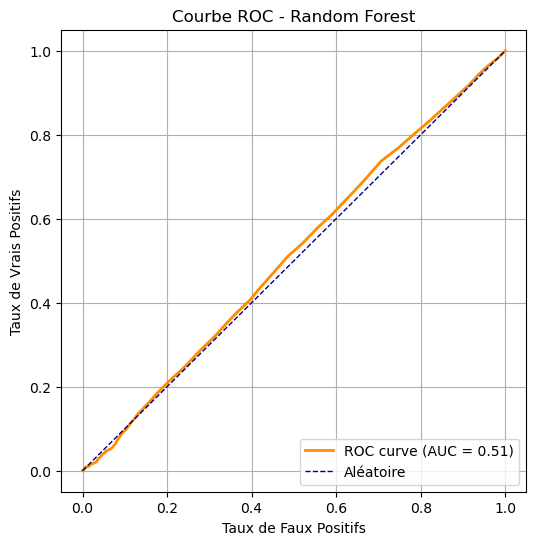

In [706]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Prédire les probabilités pour la classe positive (ici classe 1)
y_proba = modele_rf2.predict_proba(x_test)[:, 1]

# Calcul des points de la courbe ROC
fpr, tpr, seuils = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Tracé de la courbe ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Aléatoire')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Nous obtenons le même résultat que précédemment. Il faudrait certainement tenir d'un certain nombre d'information supplémentaire pour mieux faire la distinstion entre les deux classes. 

### Broken glass

In [745]:
AssuAE['broken_glass'].value_counts()

broken_glass
0    62666
1     3538
2      422
3       54
4       11
5        1
Name: count, dtype: Int64

In [746]:
import pandas as pd

# Supposons que ton DataFrame s'appelle df
# Création de la nouvelle variable
AssuAE['broken_glass_1'] = AssuAE['broken_glass'].apply(lambda x: 0 if x == 0 else 1)

In [747]:
AssuAE['broken_glass_1'].value_counts()

broken_glass_1
0    62666
1     4026
Name: count, dtype: int64

In [748]:
# Séparer les deux classes
classe_0 = AssuAE[AssuAE['broken_glass_1'] == 0].sample(n=20000, random_state=42)
classe_1 = AssuAE[AssuAE['broken_glass_1'] == 1]

# Fusionner les deux ensembles
Assu_bg = pd.concat([classe_0, classe_1], axis=0).reset_index(drop=True)
Assu_bg


,Latent1,Latent2,Latent3,md_edu_score,exposition_previous_insurance_year,bodily_accident,material_accident,broken_glass,fire,theft,other,all_claims,bodily_accident_responsible,material_accident_responsible,all_claims_responsible,bodily_accident_1,material_accident_1,broken_glass_1,fire_1
0,-4.303862,16.781458,48.919888,0,2.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-20.791899,7.100284,27.747915,73,1.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-3.846982,10.181596,48.553684,73,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.017918,10.412766,16.745277,18,2.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.502409,26.663277,15.981704,37,2.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24021,6.007800,16.183895,2.083192,50,1.00,0,1,1,0,0,0,2,0,1,1,0,1,1,0
24022,14.152207,19.257656,3.198501,78,1.00,0,0,1,0,0,1,2,0,0,0,0,0,1,0
24023,18.137632,12.175719,22.388483,47,3.00,0,0,1,0,0,0,1,0,0,0,0,0,1,0
24024,8.206018,9.201013,3.860116,49,2.75,0,1,2,0,0,0,3,0,0,0,0,1,1,0


In [749]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [750]:
y = Assu_bg['broken_glass_1']
x = Assu_bg.iloc[:,:3]#.drop(columns=['material_accident'], axis = 1)
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.25, random_state=42)


In [751]:
modele_rf3 = RandomForestClassifier(
     n_estimators=100,
     criterion='gini',
     max_depth=None,
     min_samples_split=2,
     min_samples_leaf=1,
     min_weight_fraction_leaf=0.0,
     max_features='sqrt',
     max_leaf_nodes=None,
     min_impurity_decrease=0.0,
     bootstrap=True,
     oob_score=False,
     n_jobs=None,
     random_state=42,
     verbose=0,
     warm_start=False,
     class_weight='balanced',
     ccp_alpha=0.0,
     max_samples=None,)

In [752]:
modele_rf3.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [753]:
pd.DataFrame(modele_rf3.feature_importances_, index = x_train.columns, columns = ["importance"]).sort_values("importance", ascending = False)

,importance
Latent3,0.335695
Latent1,0.334151
Latent2,0.330153


In [754]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, modele_rf3.predict(x_test))*100} %")

Le pourcentage de bien classés est de : 82.1541534875978 %


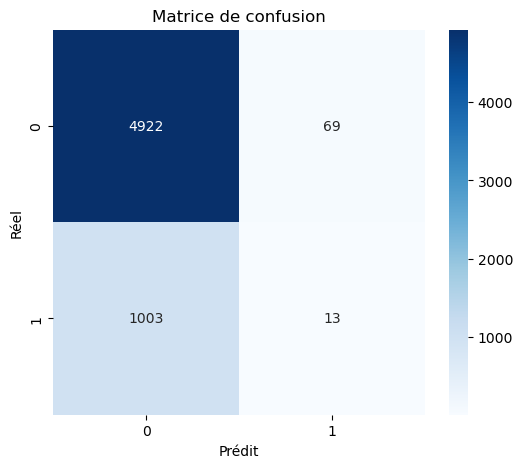

In [755]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, modele_rf3.predict(x_test))
labels = np.unique(y_test)  

# Affichage avec Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


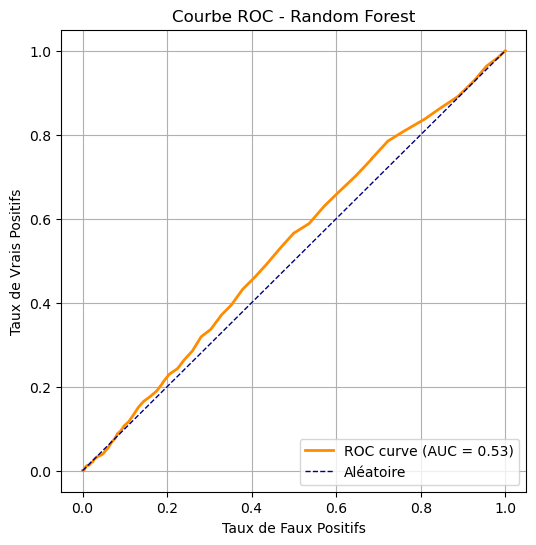

In [756]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Prédire les probabilités pour la classe positive (ici classe 1)
y_proba = modele_rf3.predict_proba(x_test)[:, 1]

# Calcul des points de la courbe ROC
fpr, tpr, seuils = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Tracé de la courbe ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Aléatoire')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Fire

In [757]:
AssuAE['fire'].value_counts()

fire
0    66553
1      138
2        1
Name: count, dtype: Int64

In [758]:
import pandas as pd

# Supposons que ton DataFrame s'appelle df
# Création de la nouvelle variable
AssuAE['fire_1'] = AssuAE['fire'].apply(lambda x: 0 if x == 0 else 1)

In [759]:
AssuAE['fire_1'].value_counts()

fire_1
0    66553
1      139
Name: count, dtype: int64

In [760]:
# Séparer les deux classes
classe_0 = AssuAE[AssuAE['fire_1'] == 0].sample(n=600, random_state=42)
classe_1 = AssuAE[AssuAE['fire_1'] == 1]

# Fusionner les deux ensembles
Assu_f = pd.concat([classe_0, classe_1], axis=0).reset_index(drop=True)
Assu_f


,Latent1,Latent2,Latent3,md_edu_score,exposition_previous_insurance_year,bodily_accident,material_accident,broken_glass,fire,theft,other,all_claims,bodily_accident_responsible,material_accident_responsible,all_claims_responsible,bodily_accident_1,material_accident_1,broken_glass_1,fire_1
0,8.231380,6.806834,10.262292,40,0.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.420211,1.190461,9.848431,0,0.75,0,0,1,0,0,0,1,0,0,0,0,0,1,0
2,0.463823,21.450754,32.124561,20,3.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7.119668,8.646523,-0.418384,82,0.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-19.846138,13.548360,28.365583,2,0.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,-3.489383,12.905105,36.144180,63,2.50,0,1,1,1,0,0,3,0,1,1,0,1,1,1
735,-1.547631,24.018717,15.593997,63,3.00,0,0,0,1,0,0,1,0,0,0,0,0,0,1
736,0.671007,7.185428,14.163305,1,3.00,0,1,1,1,0,0,3,0,0,0,0,1,1,1
737,1.780400,2.312953,3.832472,86,3.00,0,0,1,1,0,0,2,0,0,0,0,0,1,1


In [761]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [762]:
y = Assu_f['fire_1']
x = Assu_f.iloc[:,:3]#.drop(columns=['material_accident'], axis = 1)
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.25, random_state=42)


In [764]:
modele_rf4 = RandomForestClassifier(
     n_estimators=100,
     criterion='gini',
     max_depth=None,
     min_samples_split=2,
     min_samples_leaf=1,
     min_weight_fraction_leaf=0.0,
     max_features='sqrt',
     max_leaf_nodes=None,
     min_impurity_decrease=0.0,
     bootstrap=True,
     oob_score=False,
     n_jobs=None,
     random_state=42,
     verbose=0,
     warm_start=False,
     class_weight='balanced',
     ccp_alpha=0.0,
     max_samples=None,)

In [765]:
modele_rf4.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [766]:
pd.DataFrame(modele_rf4.feature_importances_, index = x_train.columns, columns = ["importance"]).sort_values("importance", ascending = False)

,importance
Latent2,0.336580
Latent3,0.335928
Latent1,0.327492


In [767]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, modele_rf4.predict(x_test))*100} %")

Le pourcentage de bien classés est de : 80.0 %


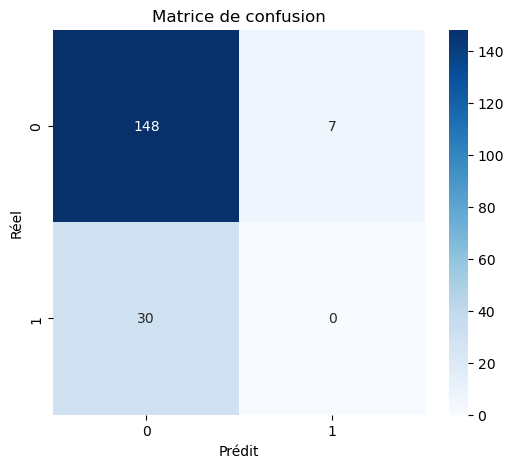

In [768]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, modele_rf4.predict(x_test))
labels = np.unique(y_test)  

# Affichage avec Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


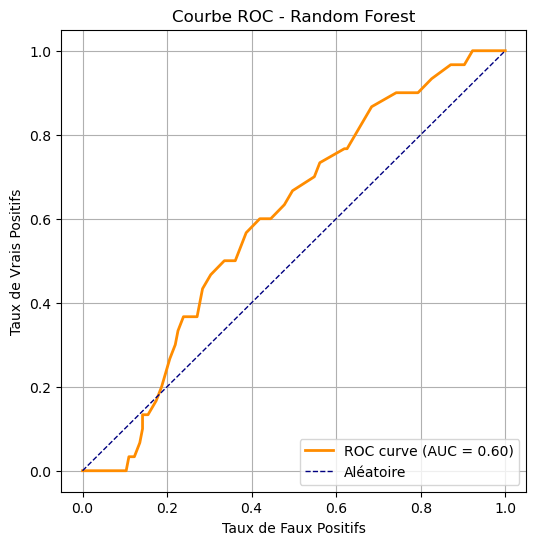

In [769]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Prédire les probabilités pour la classe positive (ici classe 1)
y_proba = modele_rf4.predict_proba(x_test)[:, 1]

# Calcul des points de la courbe ROC
fpr, tpr, seuils = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Tracé de la courbe ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Aléatoire')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Gradiant Boosting

### Assu2

In [670]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

In [671]:
y = Assu2RF['bodily_accident_1']
x = Assu2RF.iloc[:,:3]#.drop(columns=['material_accident'], axis = 1)
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.25, random_state=42)


In [672]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [673]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=42)
    gb_clf.fit(x_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(x_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(x_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.820
Accuracy score (validation): 0.848
Learning rate:  0.075
Accuracy score (training): 0.820
Accuracy score (validation): 0.848
Learning rate:  0.1
Accuracy score (training): 0.820
Accuracy score (validation): 0.848
Learning rate:  0.25
Accuracy score (training): 0.821
Accuracy score (validation): 0.848
Learning rate:  0.5
Accuracy score (training): 0.827
Accuracy score (validation): 0.830
Learning rate:  0.75
Accuracy score (training): 0.837
Accuracy score (validation): 0.833
Learning rate:  1
Accuracy score (training): 0.835
Accuracy score (validation): 0.828


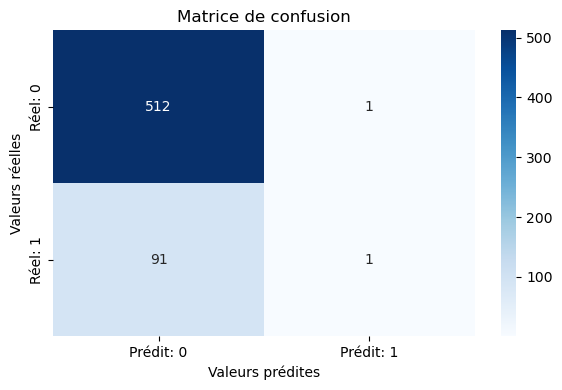

Rapport de classification

              precision  recall  f1-score  support
0                  0.85    1.00      0.92   513.00
1                  0.50    0.01      0.02    92.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.67    0.50      0.47   605.00
weighted avg       0.80    0.85      0.78   605.00


In [675]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Entraînement du modèle
gb_clf2 = GradientBoostingClassifier(
    n_estimators=20, learning_rate=0.25, max_features=2, max_depth=2, random_state=42
)
gb_clf2.fit(x_train, y_train)

# Prédictions
predictions = gb_clf2.predict(x_test)

# Récupération des labels uniques
labels = np.unique(np.concatenate((y_test, predictions)))

# Affichage de la matrice de confusion automatisée
cm = confusion_matrix(y_test, predictions, labels=labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Prédit: {label}" for label in labels],
            yticklabels=[f"Réel: {label}" for label in labels])
plt.title("Matrice de confusion")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.tight_layout()
plt.show()

# Rapport de classification
report = classification_report(y_test, predictions, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("Rapport de classification\n")
print(df_report.round(2))


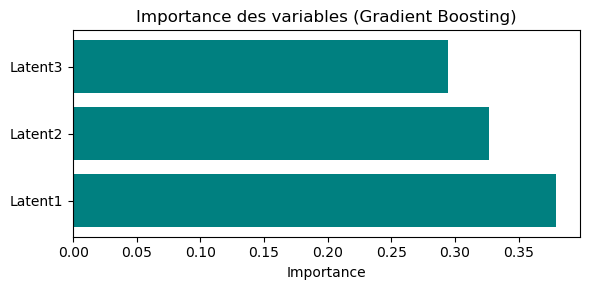

In [676]:
import matplotlib.pyplot as plt

importances = gb_clf2.feature_importances_
feature_names = ['Latent1', 'Latent2', 'Latent3']

plt.figure(figsize=(6, 3))
plt.barh(feature_names, importances, color="teal")
plt.xlabel("Importance")
plt.title("Importance des variables (Gradient Boosting)")
plt.tight_layout()
plt.show()


### Assu3

In [679]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

In [680]:
y = Assu3RF['material_accident_1']
x = Assu3RF.iloc[:,:3]#.drop(columns=['material_accident'], axis = 1)
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.25, random_state=42)


In [681]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [682]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=42)
    gb_clf.fit(x_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(x_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(x_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.811
Accuracy score (validation): 0.807
Learning rate:  0.075
Accuracy score (training): 0.811
Accuracy score (validation): 0.807
Learning rate:  0.1
Accuracy score (training): 0.811
Accuracy score (validation): 0.807
Learning rate:  0.25
Accuracy score (training): 0.811
Accuracy score (validation): 0.807
Learning rate:  0.5
Accuracy score (training): 0.812
Accuracy score (validation): 0.806
Learning rate:  0.75
Accuracy score (training): 0.812
Accuracy score (validation): 0.806
Learning rate:  1
Accuracy score (training): 0.811
Accuracy score (validation): 0.805


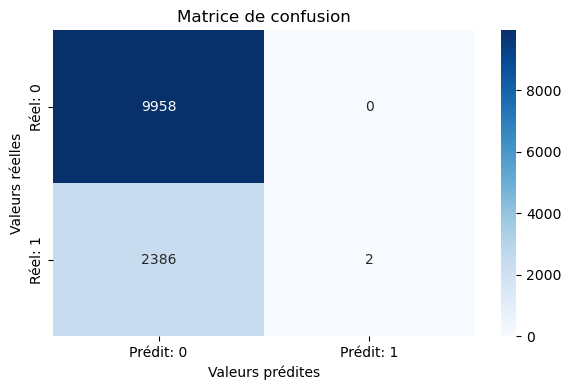

Rapport de classification

              precision  recall  f1-score   support
0                  0.81    1.00      0.89   9958.00
1                  1.00    0.00      0.00   2388.00
accuracy           0.81    0.81      0.81      0.81
macro avg          0.90    0.50      0.45  12346.00
weighted avg       0.84    0.81      0.72  12346.00


In [683]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Entraînement du modèle
gb_clf2 = GradientBoostingClassifier(
    n_estimators=20, learning_rate=0.25, max_features=2, max_depth=2, random_state=42
)
gb_clf2.fit(x_train, y_train)

# Prédictions
predictions = gb_clf2.predict(x_test)

# Récupération des labels uniques
labels = np.unique(np.concatenate((y_test, predictions)))

# Affichage de la matrice de confusion automatisée
cm = confusion_matrix(y_test, predictions, labels=labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Prédit: {label}" for label in labels],
            yticklabels=[f"Réel: {label}" for label in labels])
plt.title("Matrice de confusion")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.tight_layout()
plt.show()

# Rapport de classification
report = classification_report(y_test, predictions, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("Rapport de classification\n")
print(df_report.round(2))


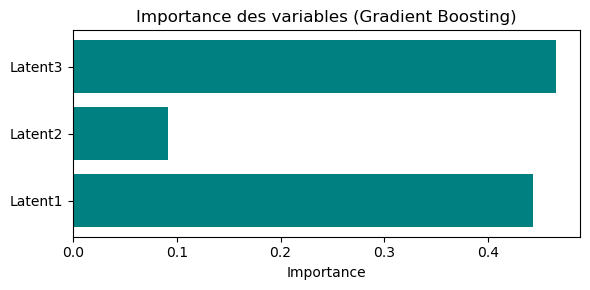

In [684]:
import matplotlib.pyplot as plt

importances = gb_clf2.feature_importances_
feature_names = ['Latent1', 'Latent2', 'Latent3']

plt.figure(figsize=(6, 3))
plt.barh(feature_names, importances, color="teal")
plt.xlabel("Importance")
plt.title("Importance des variables (Gradient Boosting)")
plt.tight_layout()
plt.show()
